# PDE via FEM

/var/folders/j8/f5pb70wx5gn1qv1nz77lfhyr0000gn/T/ipykernel_82803/4137282316.py:48: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  area = simps(y, sol.x)
/var/folders/j8/f5pb70wx5gn1qv1nz77lfhyr0000gn/T/ipykernel_82803/4137282316.py:59: UserWarning: 3 significant figures requested from number with only 1 significant figures
  plt.title(f"Steady-State [Km={sigfig.round(Km,3)} Vmax={sigfig.round(int(Vmax),3,format='scientific')}] glucose consumption")
/var/folders/j8/f5pb70wx5gn1qv1nz77lfhyr0000gn/T/ipykernel_82803/4137282316.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()
/var/folders/j8/f5pb70wx5gn1qv1nz77lfhyr00

['0.001_10000000000.0', np.float64(8.878130981788152)]
1.2e-13


/var/folders/j8/f5pb70wx5gn1qv1nz77lfhyr0000gn/T/ipykernel_82803/4137282316.py:78: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  area = simps(y, sol.x)
/var/folders/j8/f5pb70wx5gn1qv1nz77lfhyr0000gn/T/ipykernel_82803/4137282316.py:88: UserWarning: 3 significant figures requested from number with only 1 significant figures
  plt.title(f"Steady-State [Km={sigfig.round(Km,3)} Vmax={sigfig.round(Vmax,3)}] glucose consumption")
/var/folders/j8/f5pb70wx5gn1qv1nz77lfhyr0000gn/T/ipykernel_82803/4137282316.py:88: UserWarning: 3 significant figures requested from number with only 2 significant figures
  plt.title(f"Steady-State [Km={sigfig.round(Km,3)} Vmax={sigfig.round(Vmax,3)}] glucose consumption")
/var/folders/j8/f5pb70wx5gn1qv1nz77lfhyr0000gn/T/ipykernel_82803/4137282316.py:101: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy

1.82e-10 mmol glucose absorbed in the cell, and 363.0 average concentration.
1.82e-10 mmol glucose absorbed in the cell, and 363.0 average concentration.


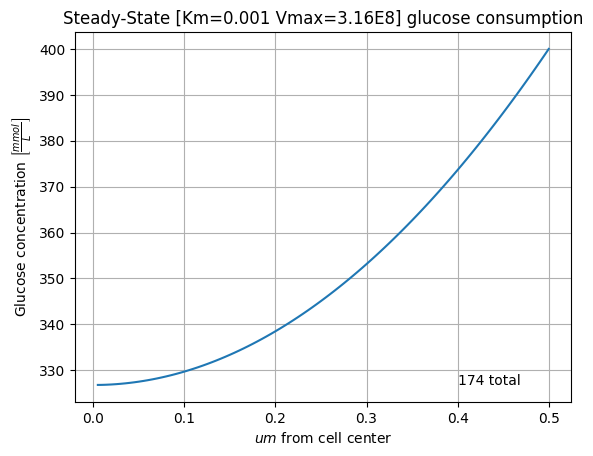

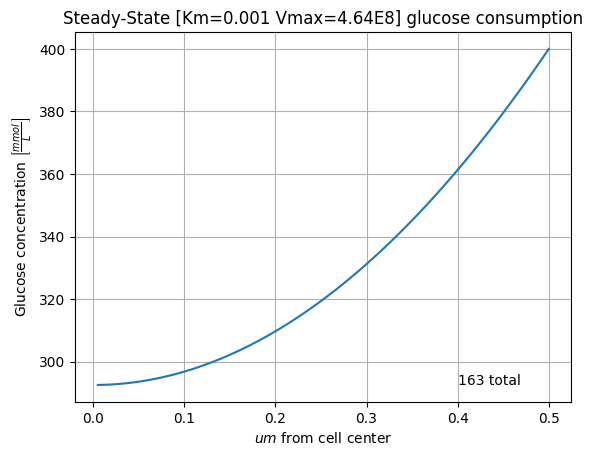

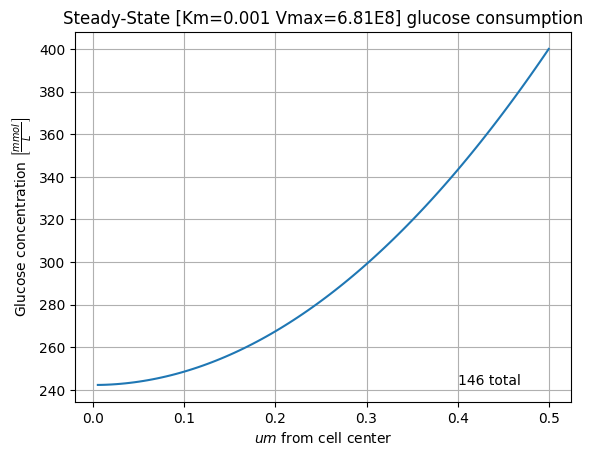

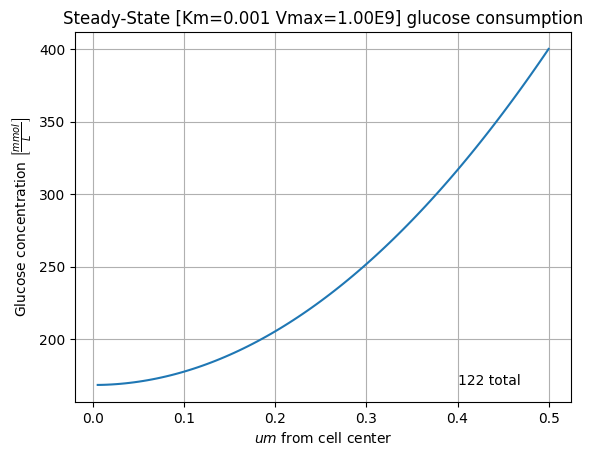

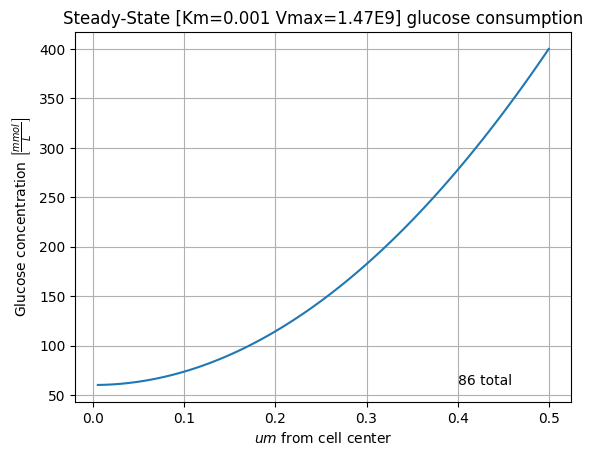

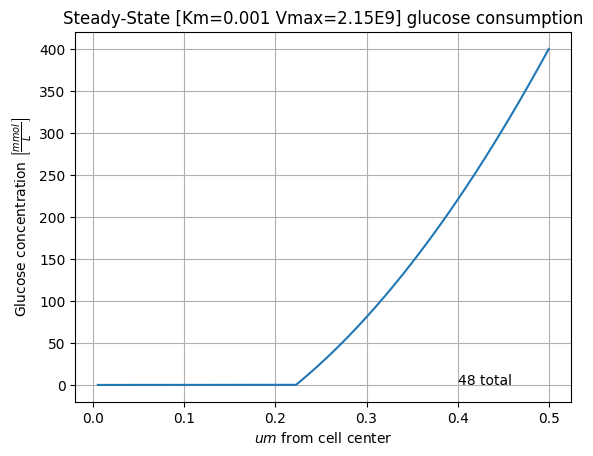

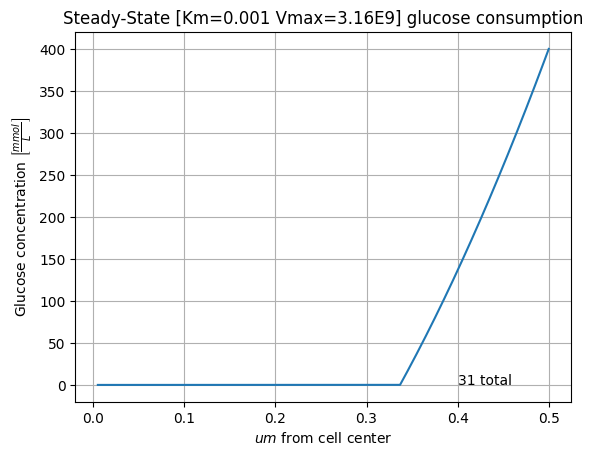

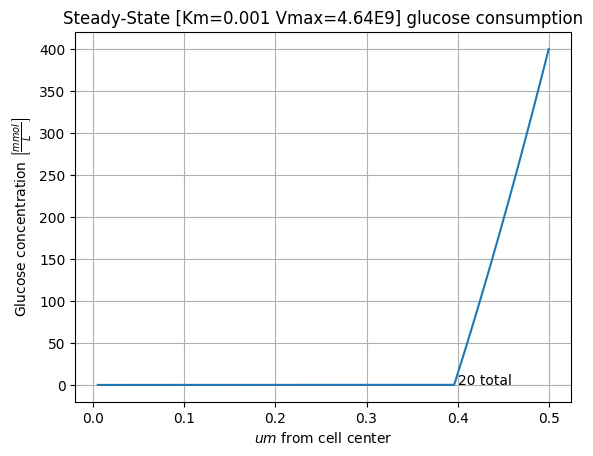

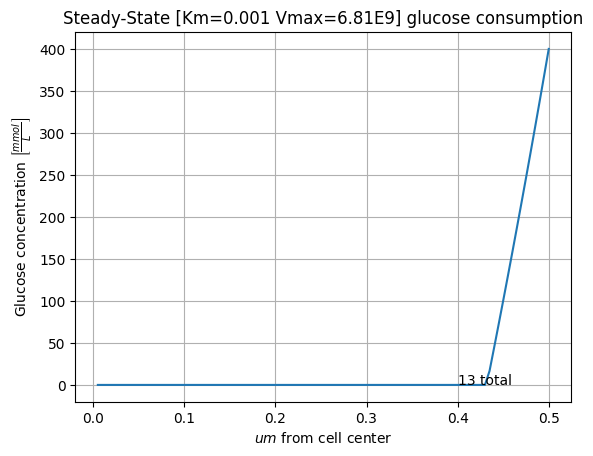

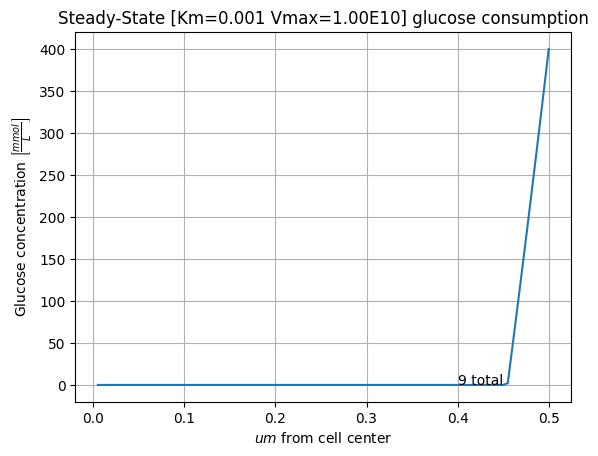

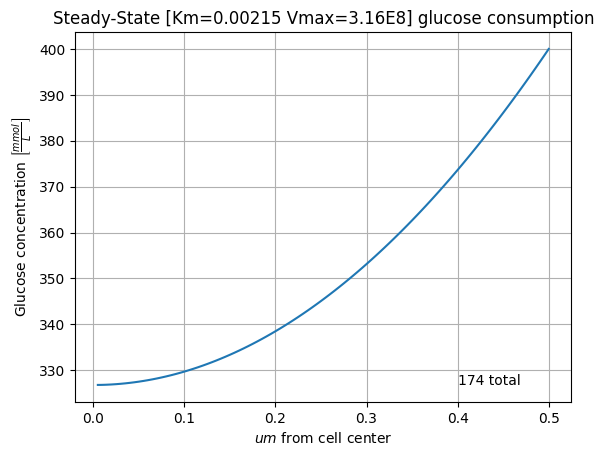

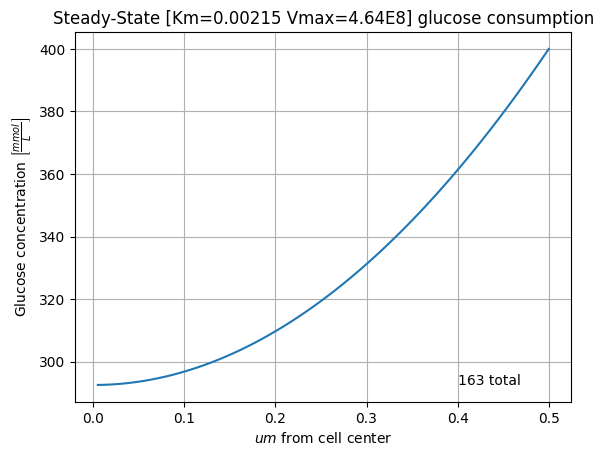

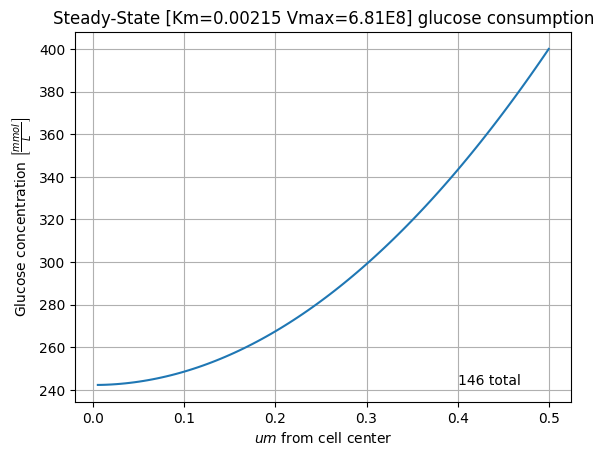

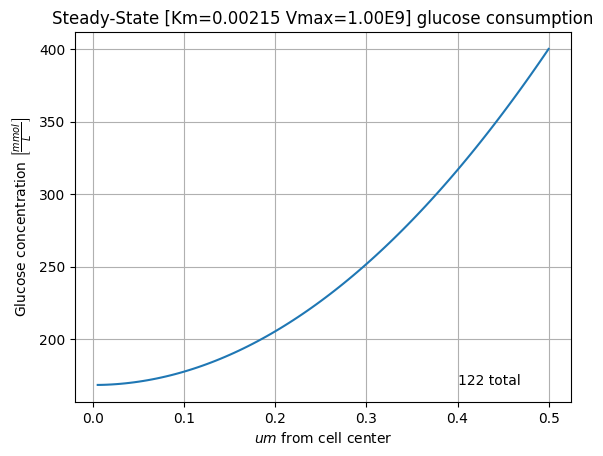

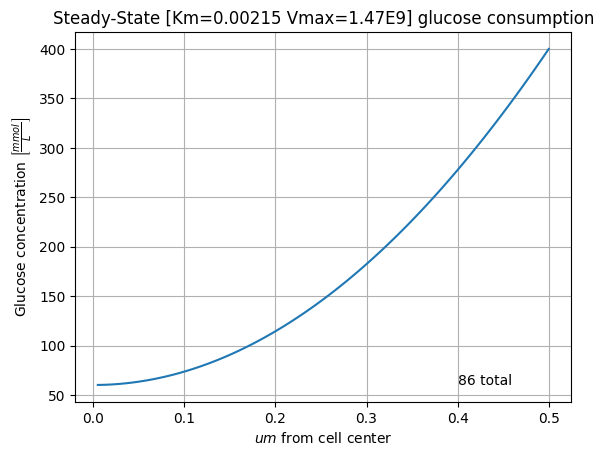

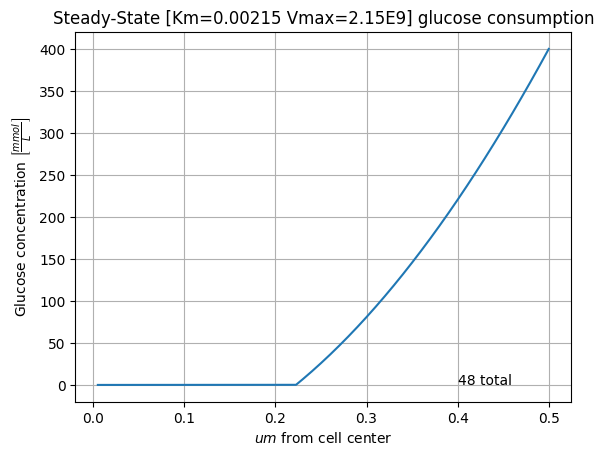

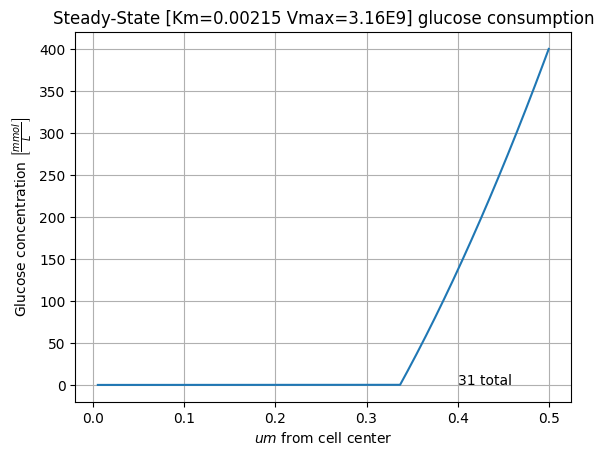

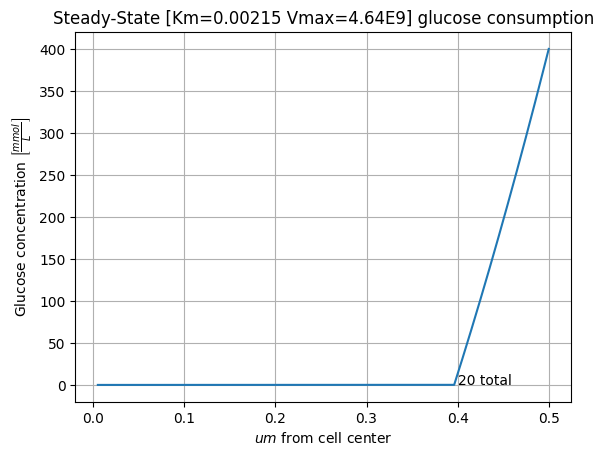

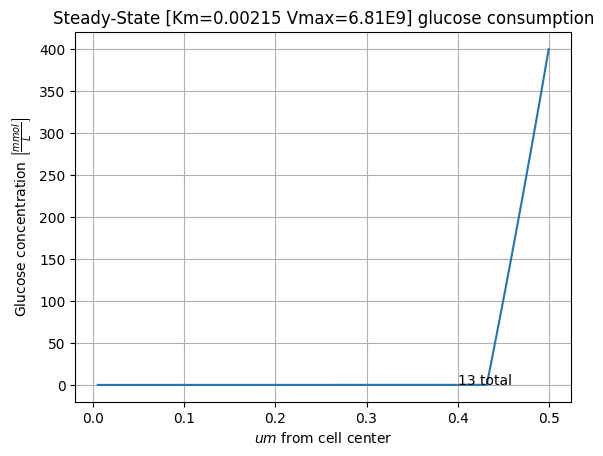

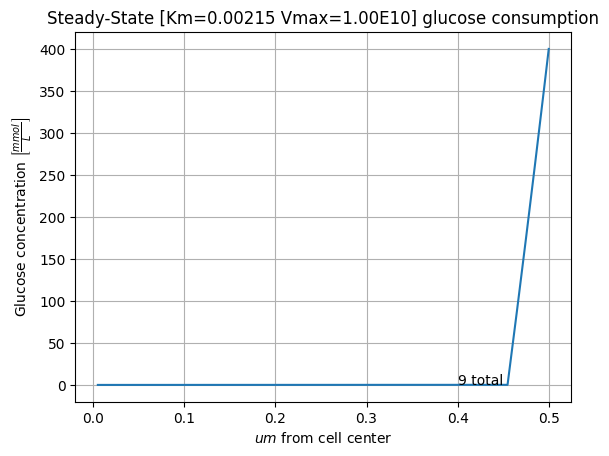

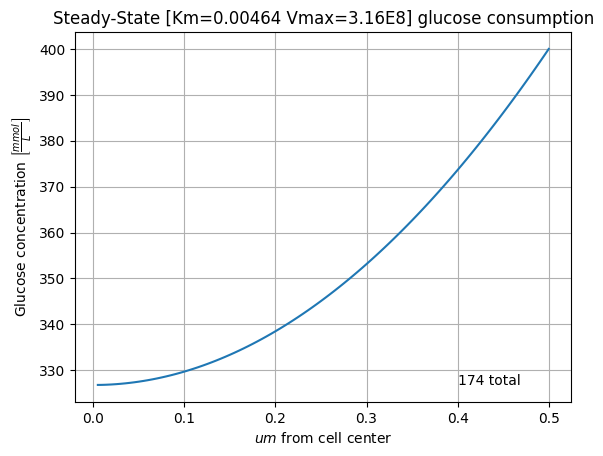

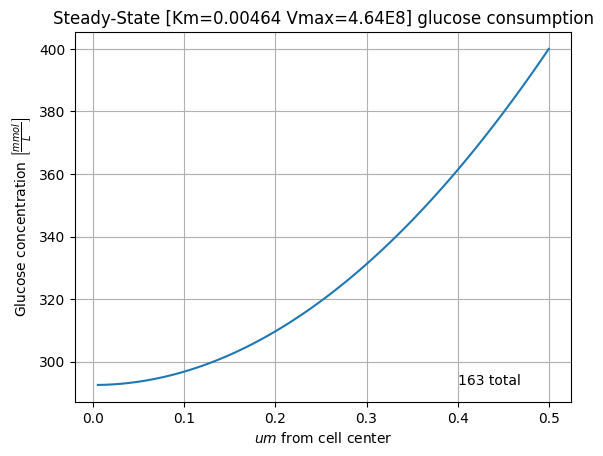

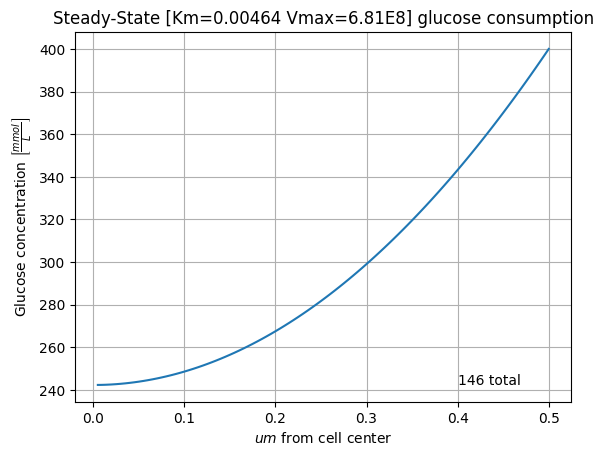

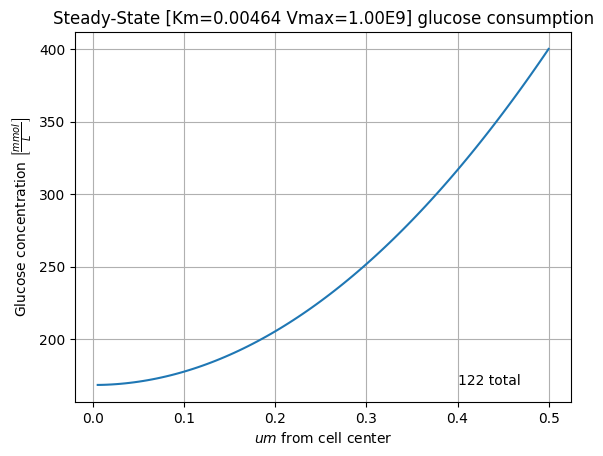

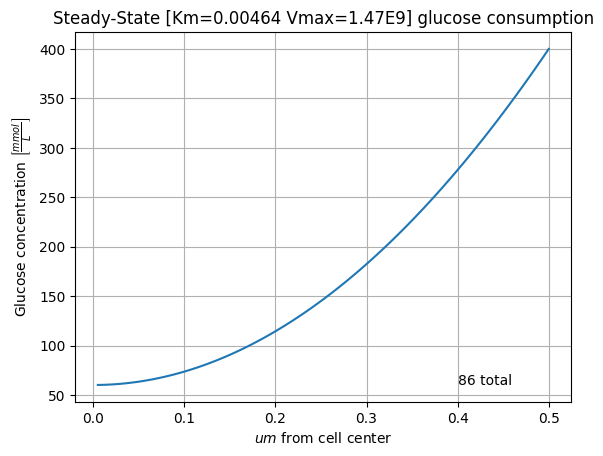

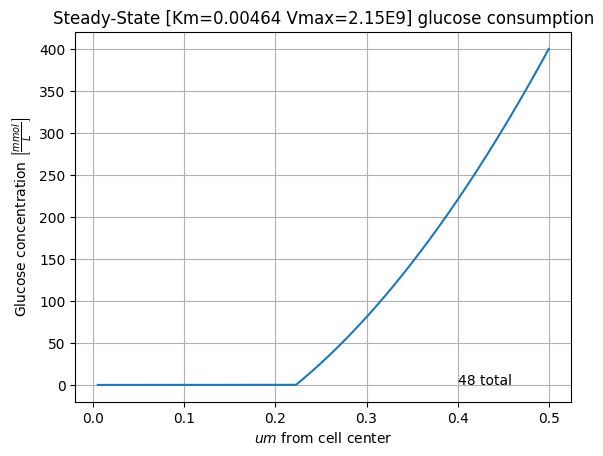

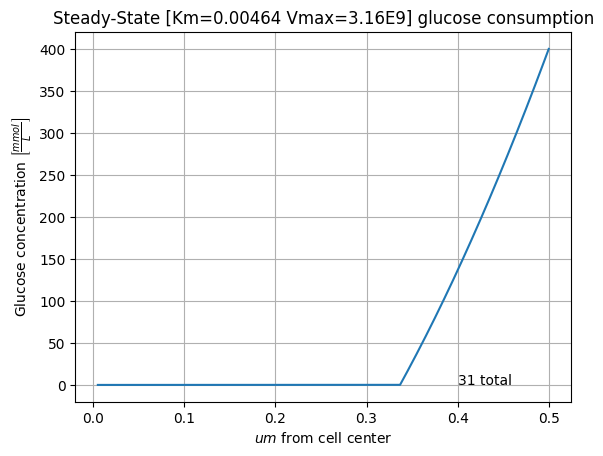

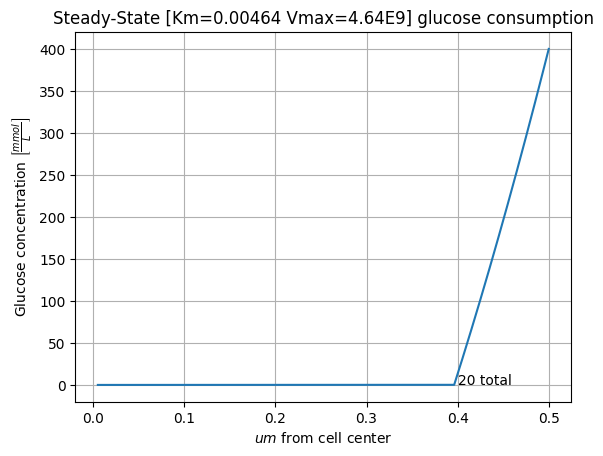

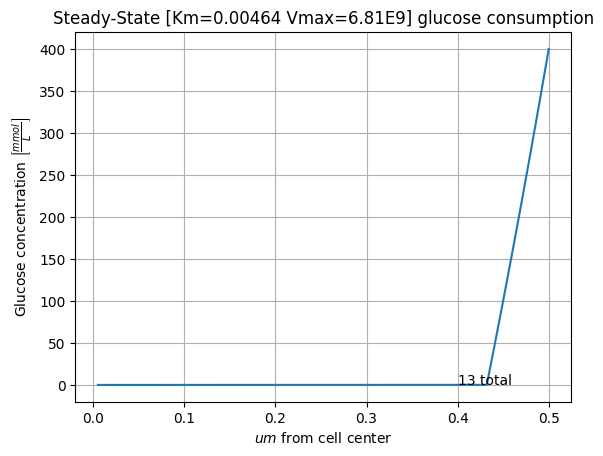

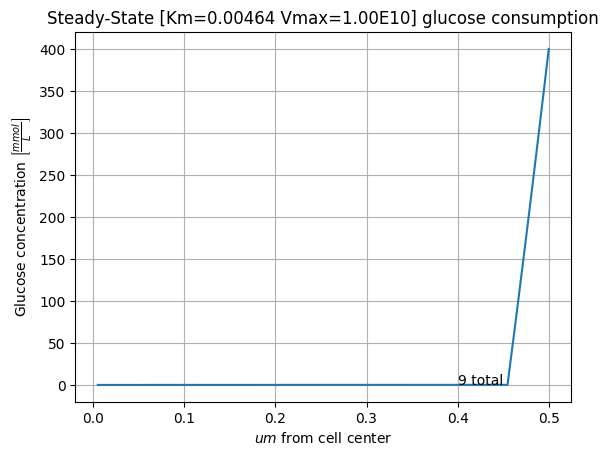

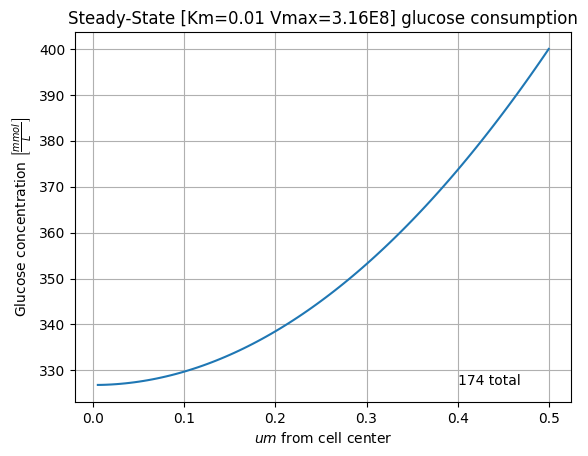

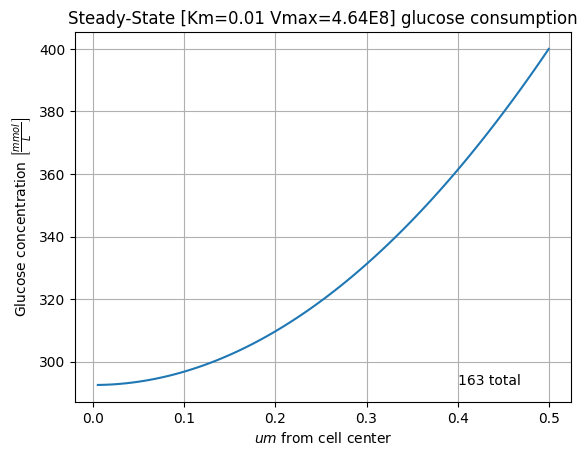

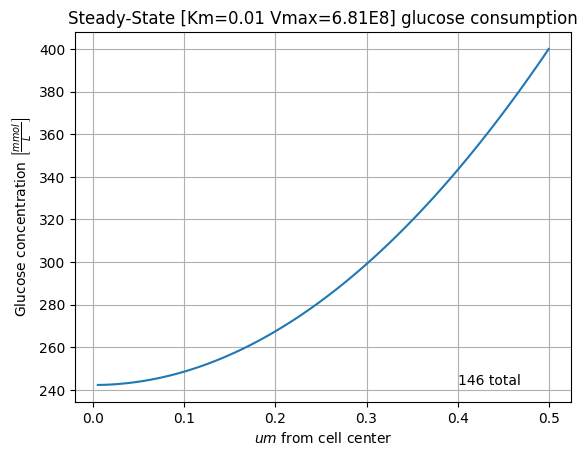

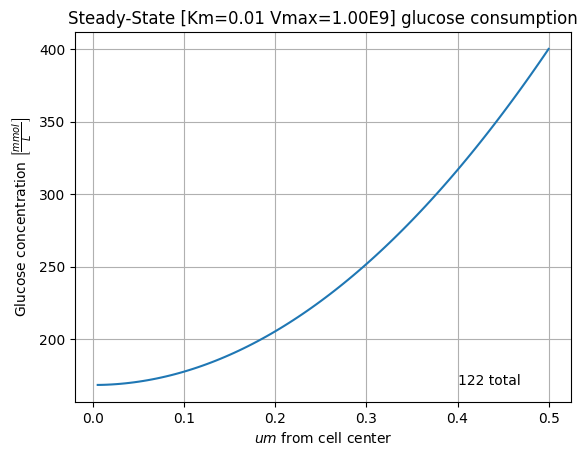

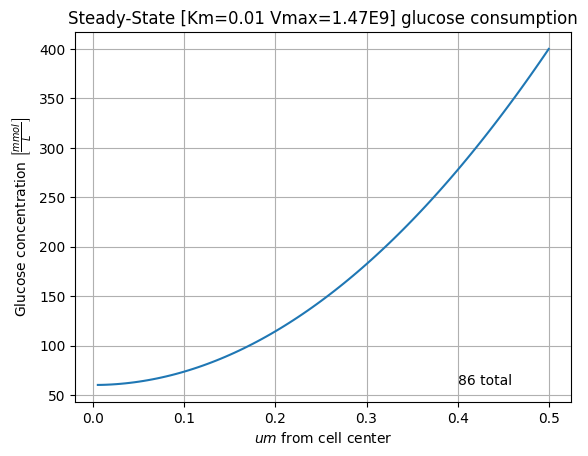

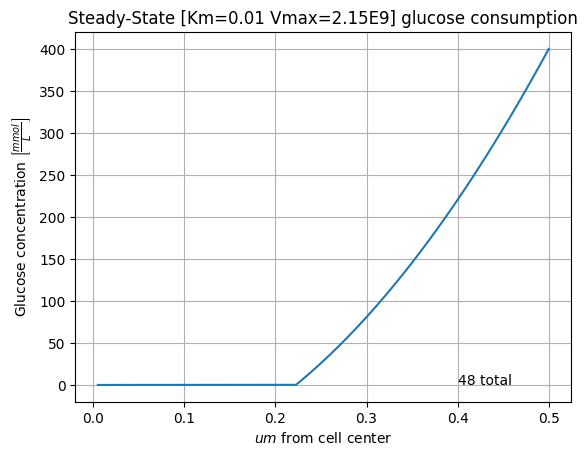

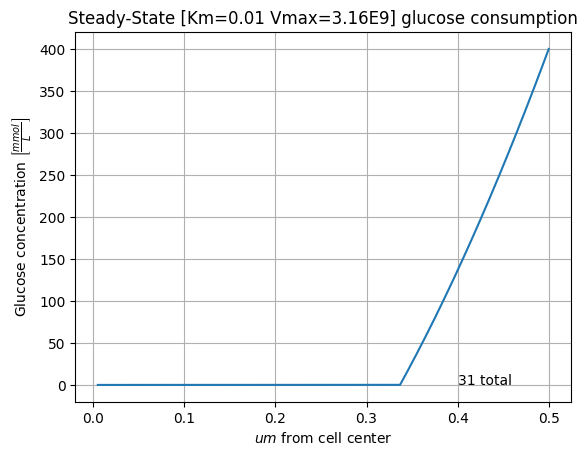

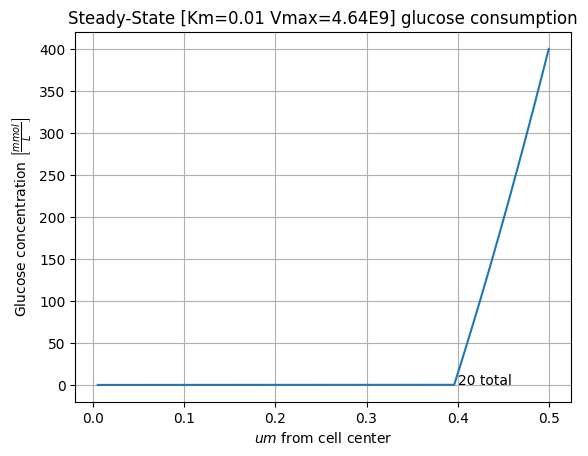

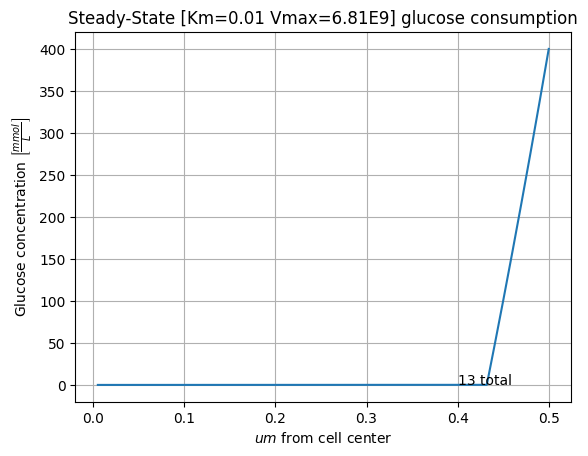

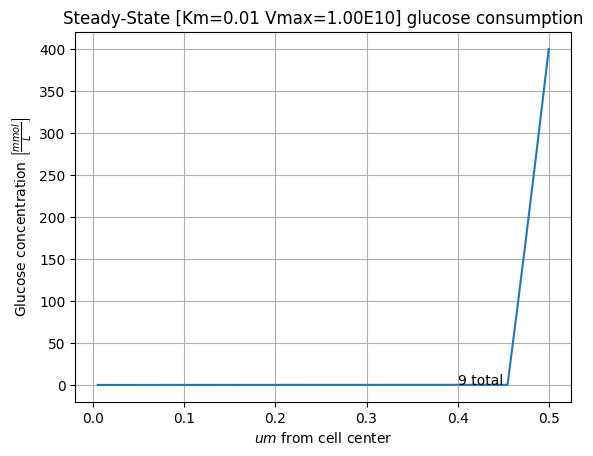

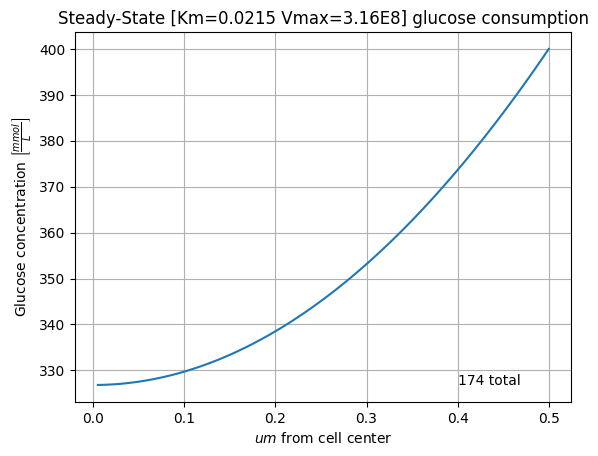

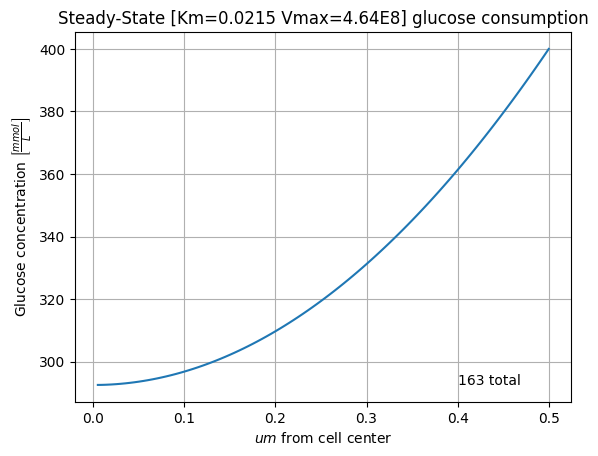

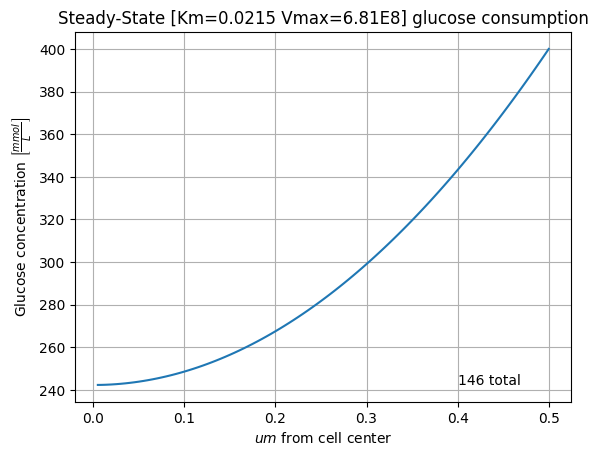

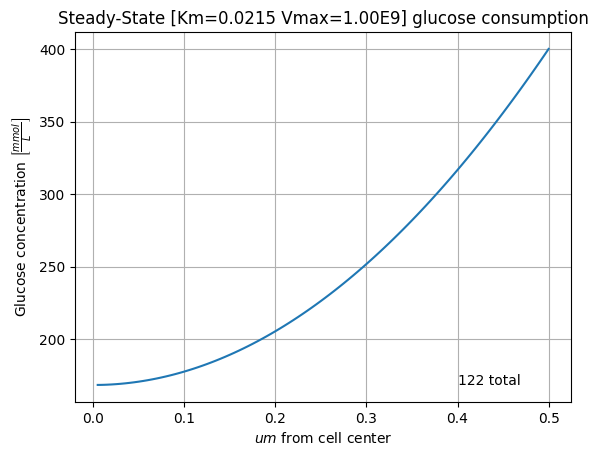

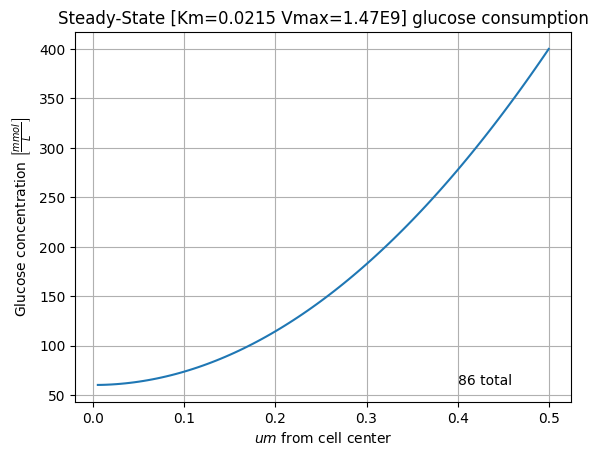

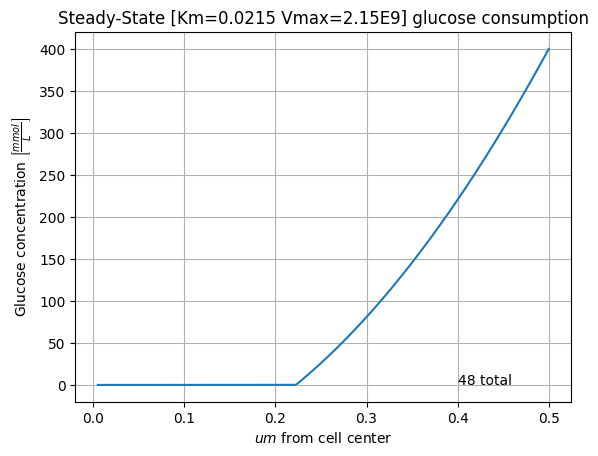

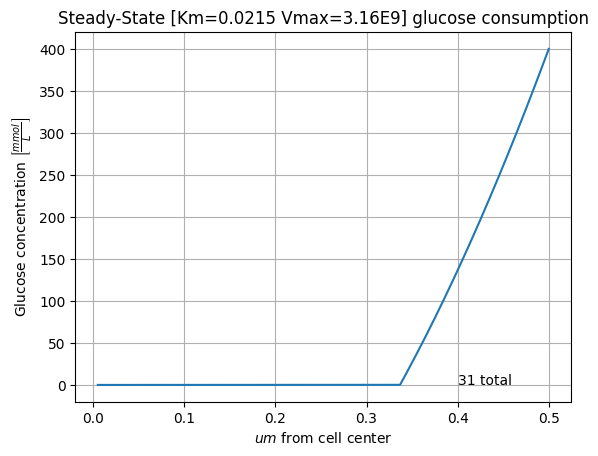

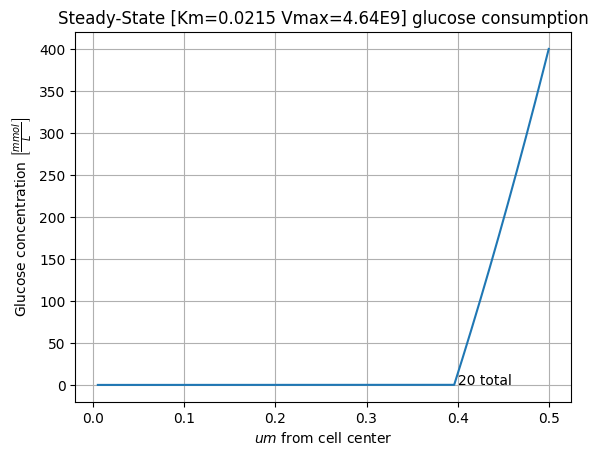

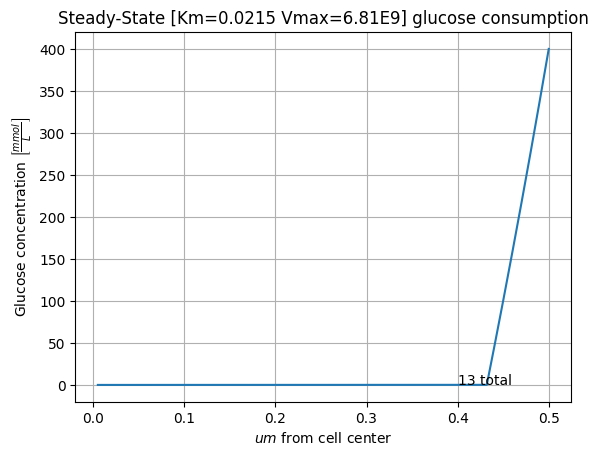

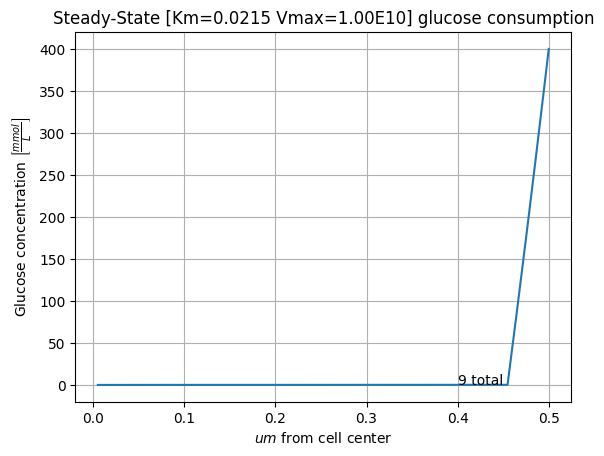

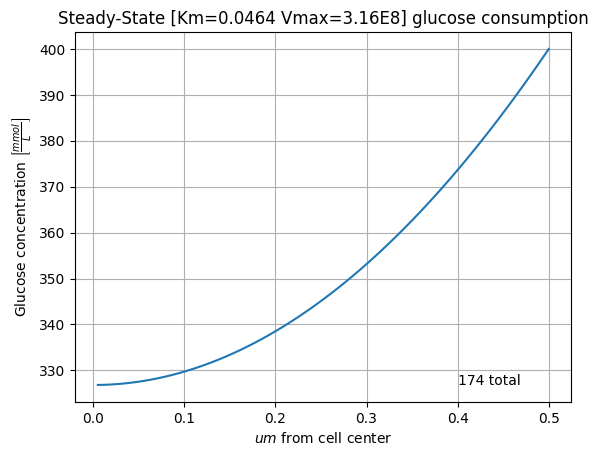

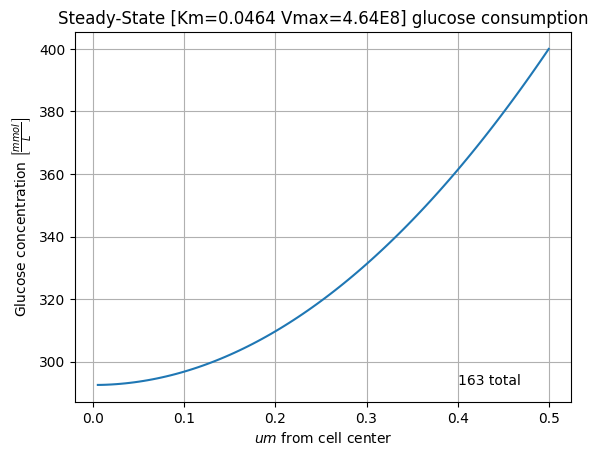

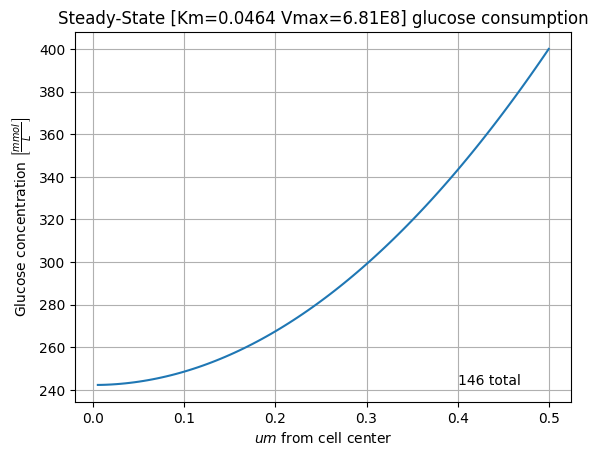

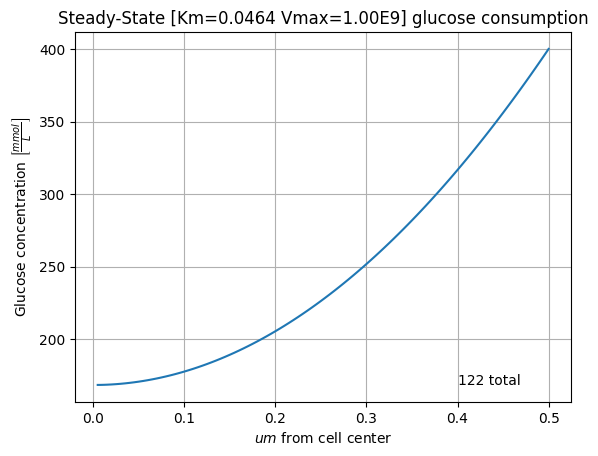

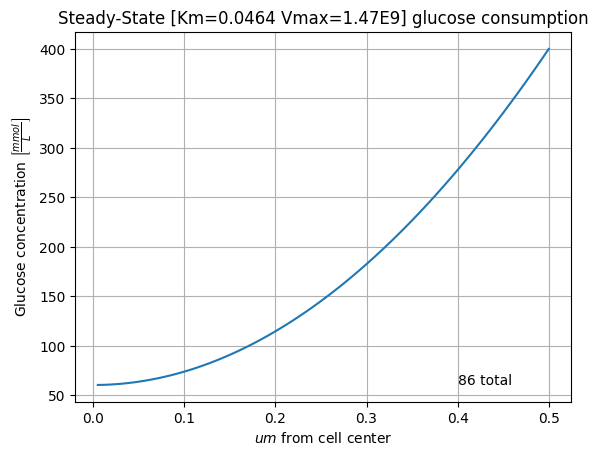

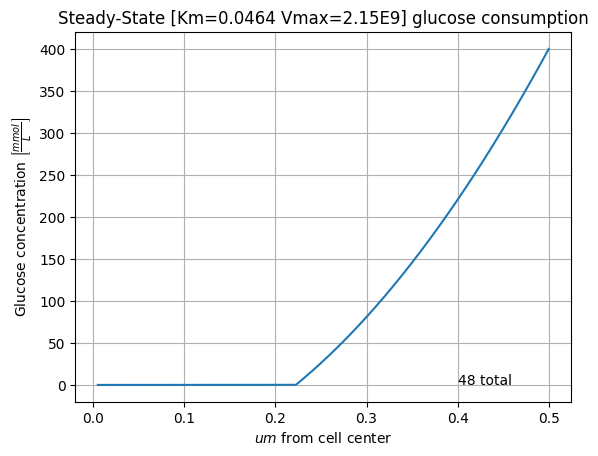

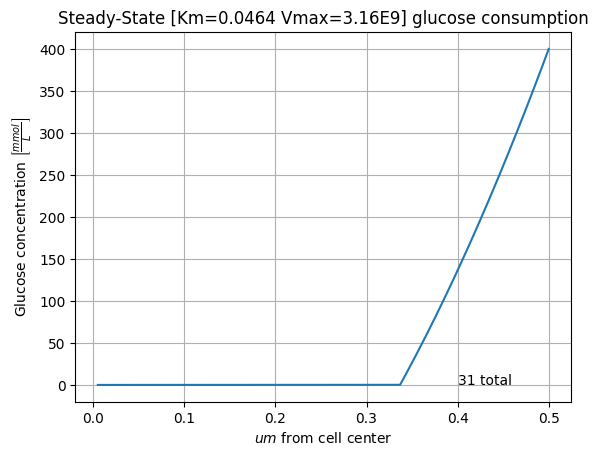

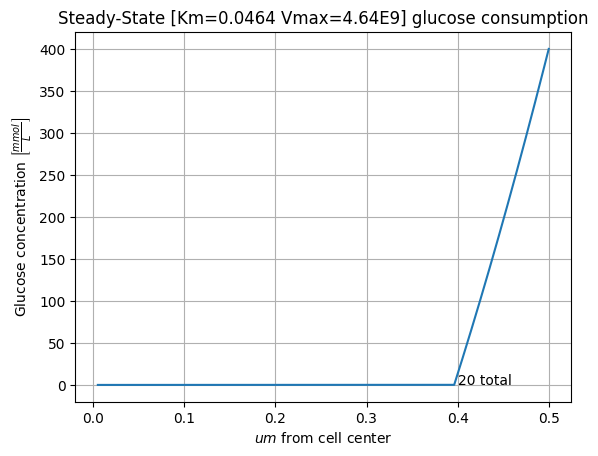

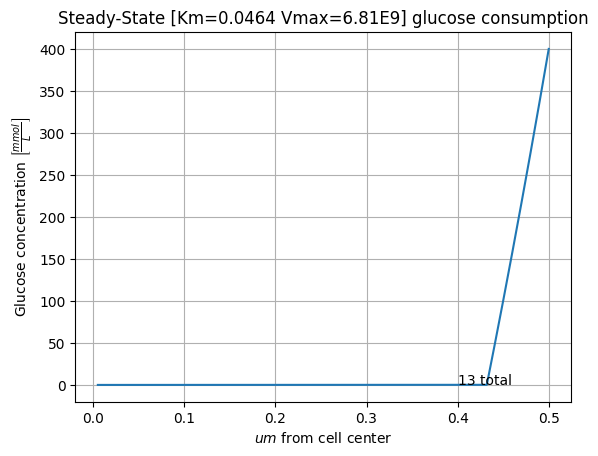

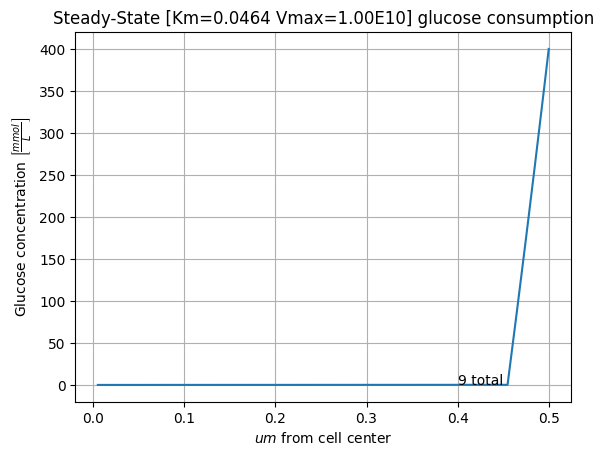

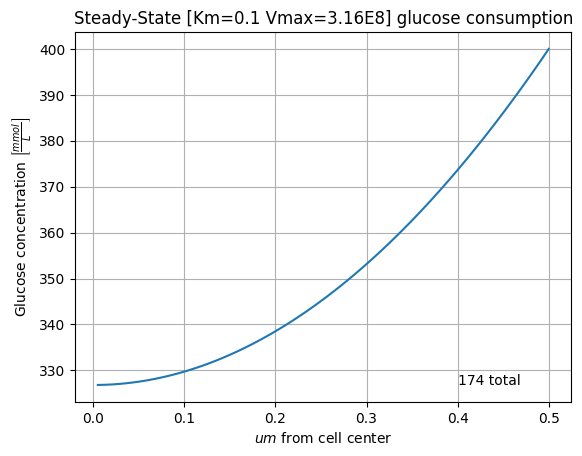

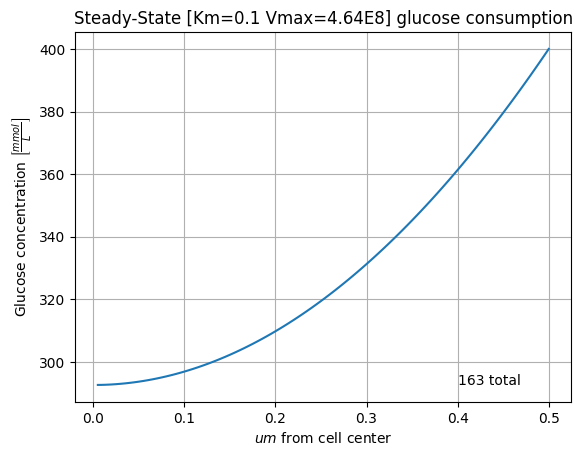

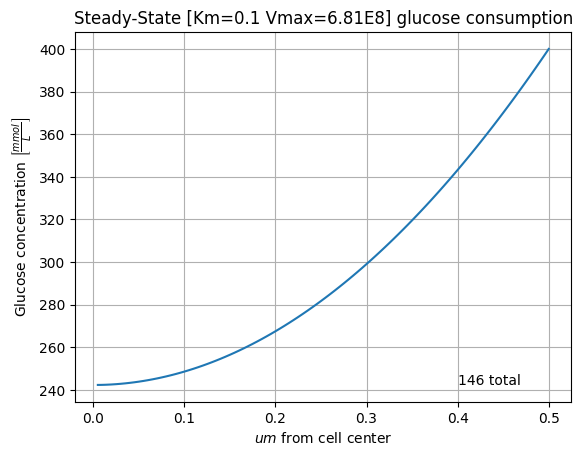

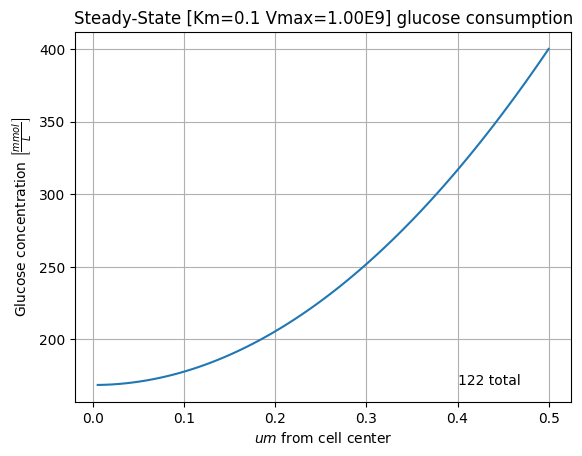

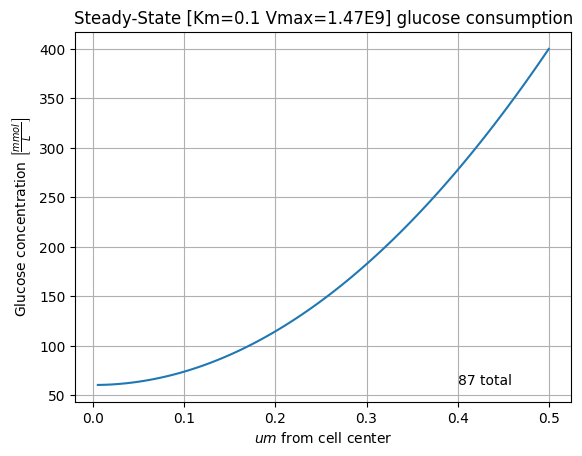

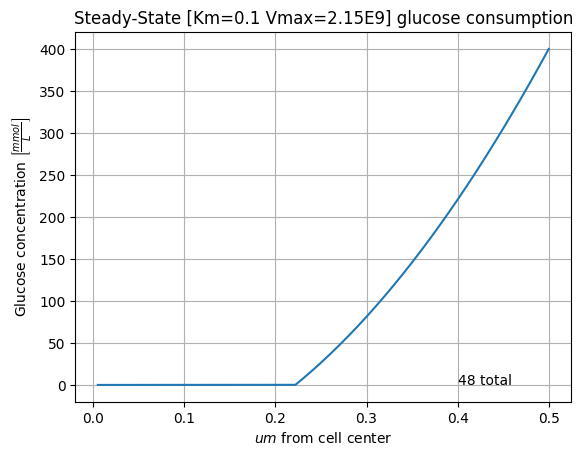

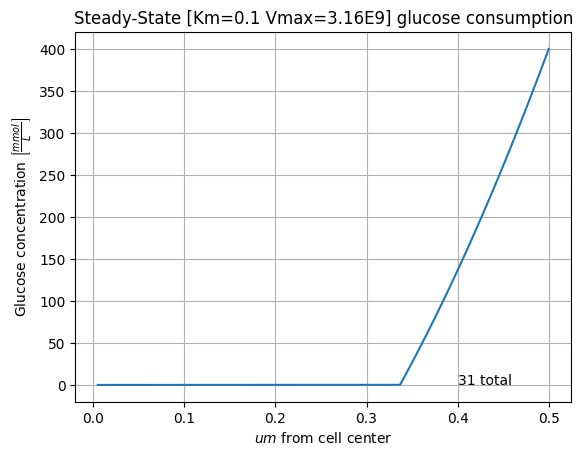

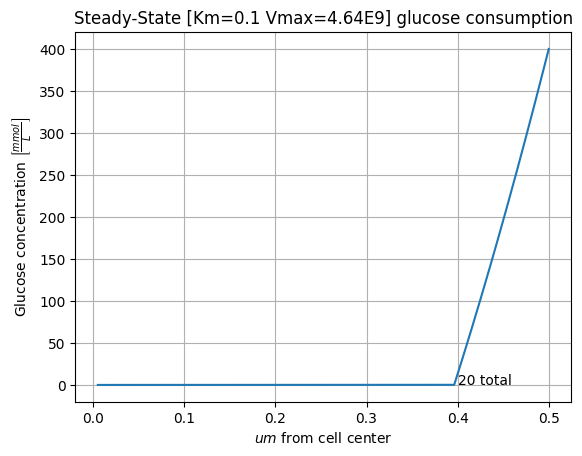

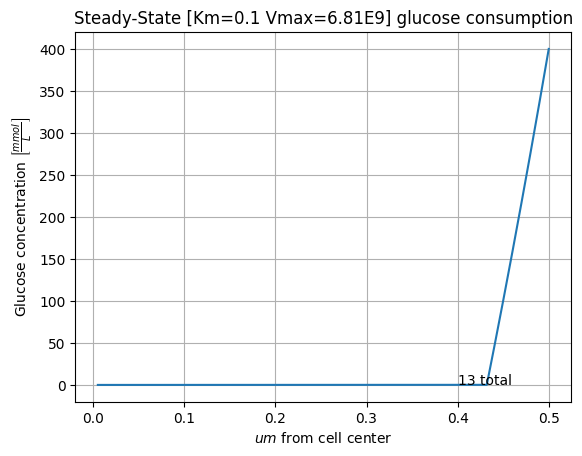

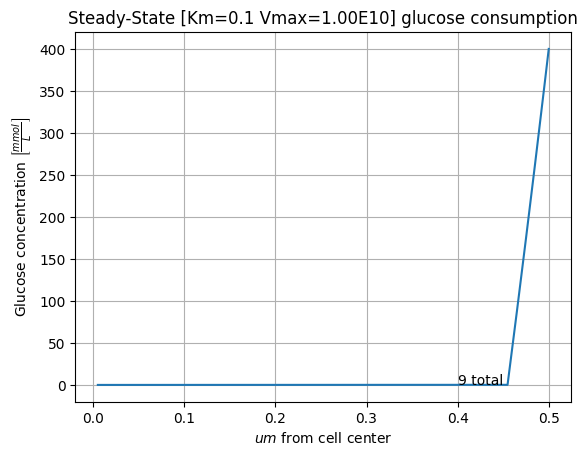

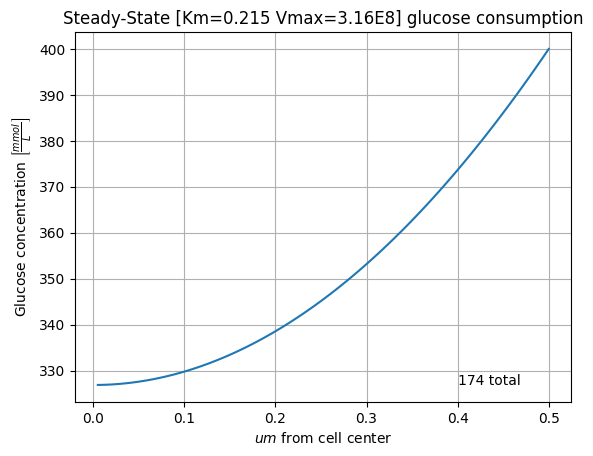

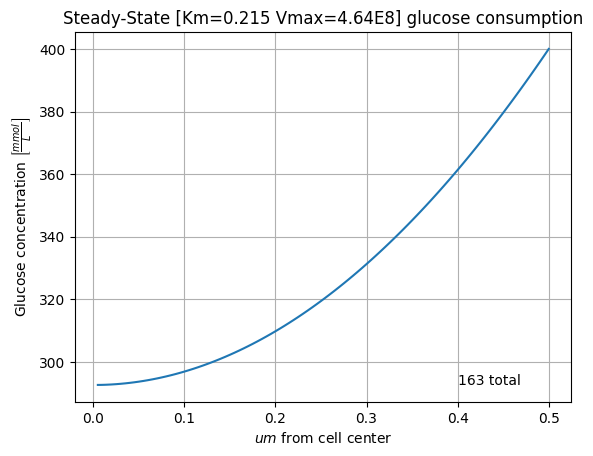

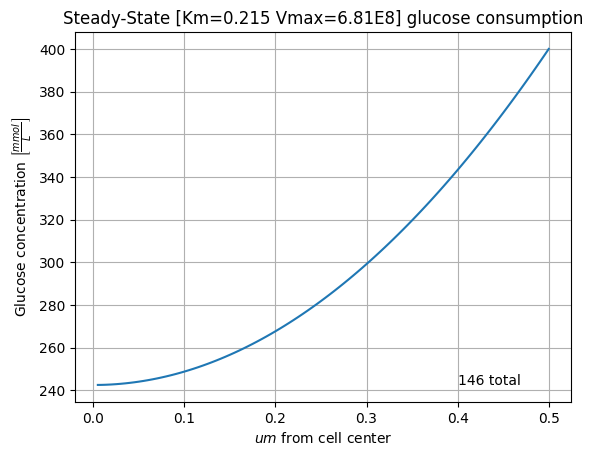

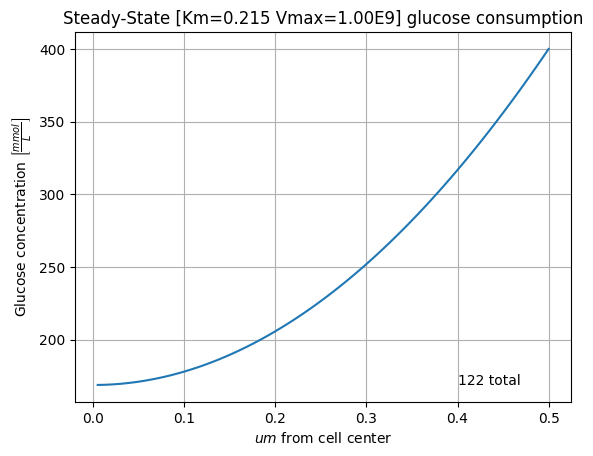

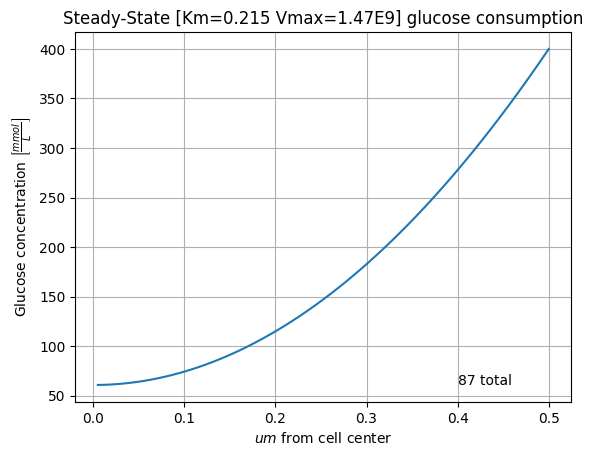

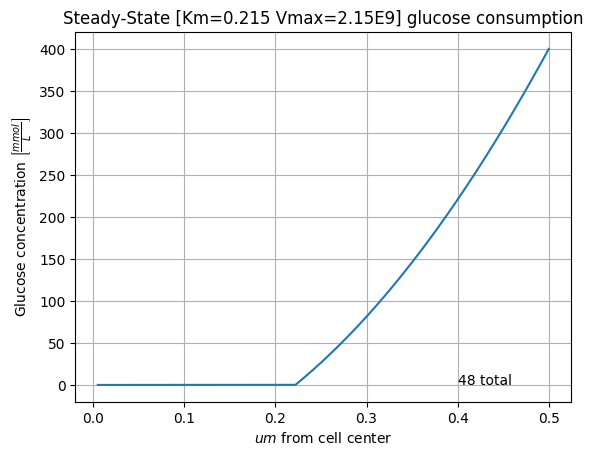

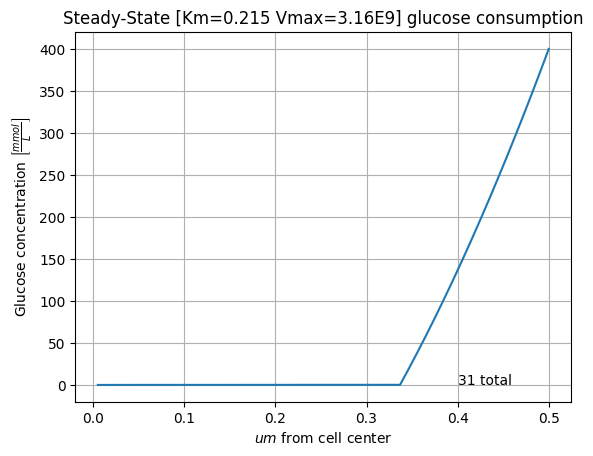

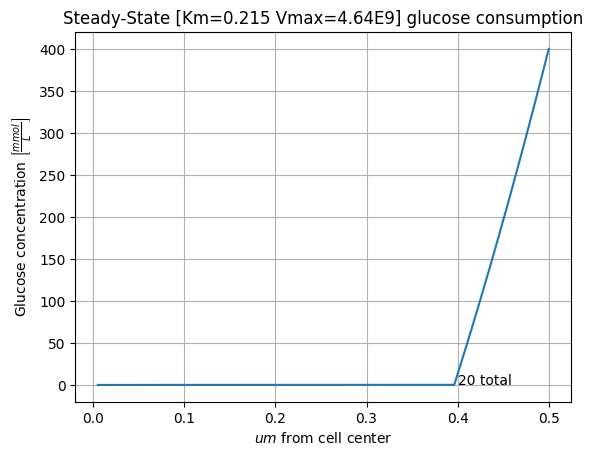

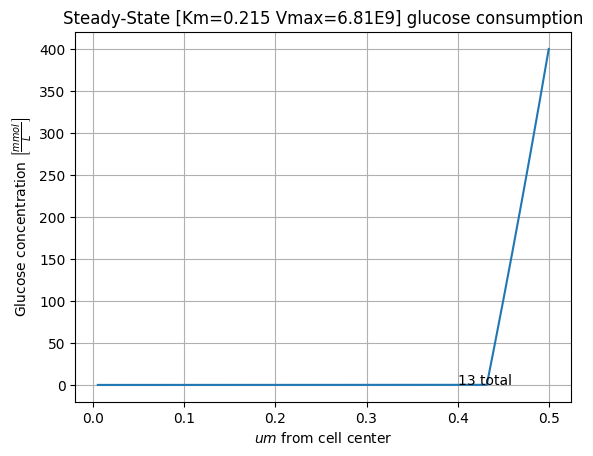

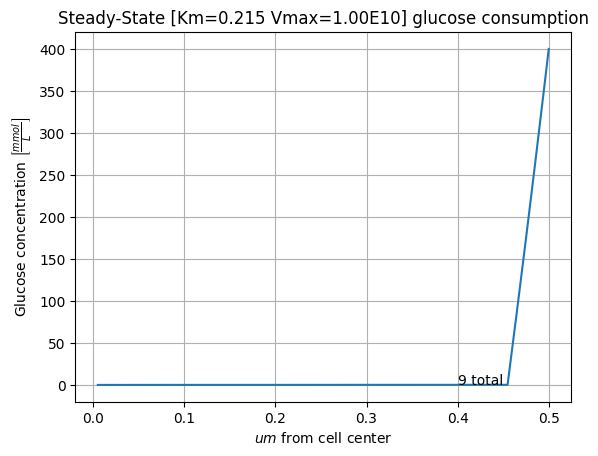

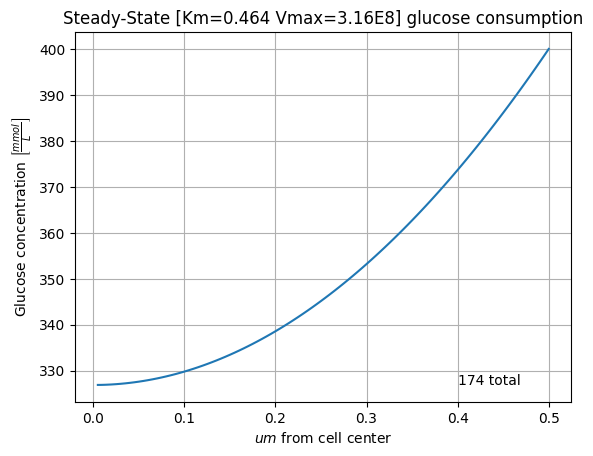

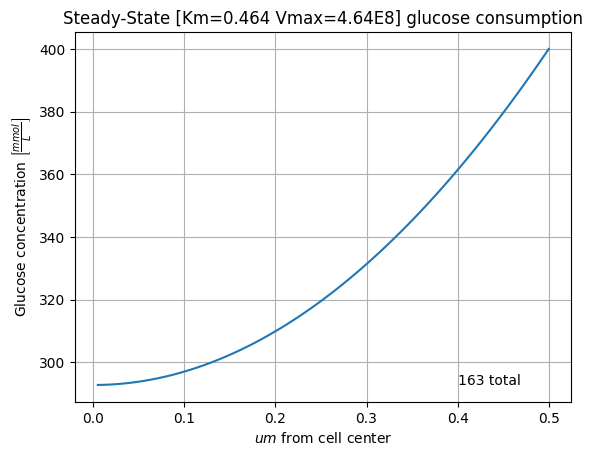

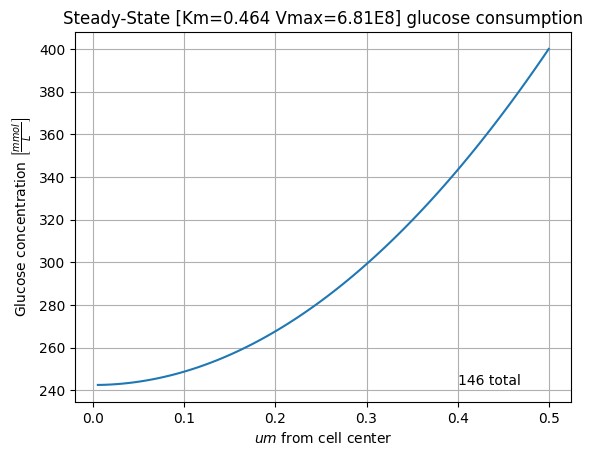

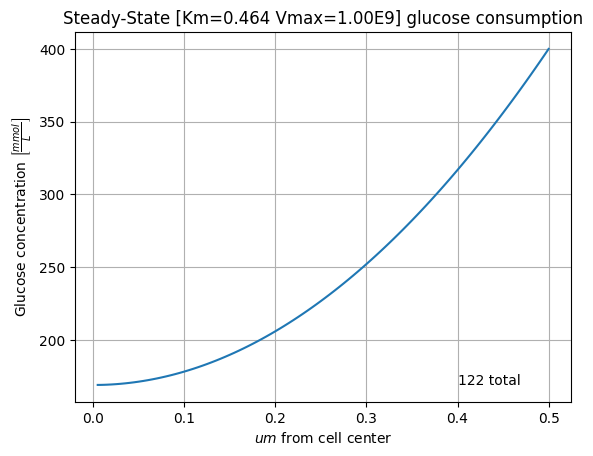

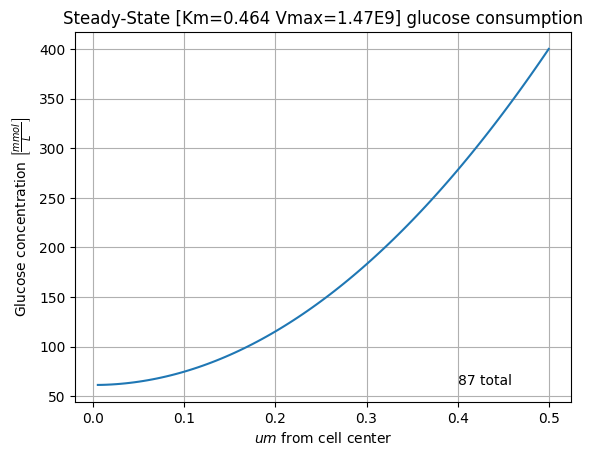

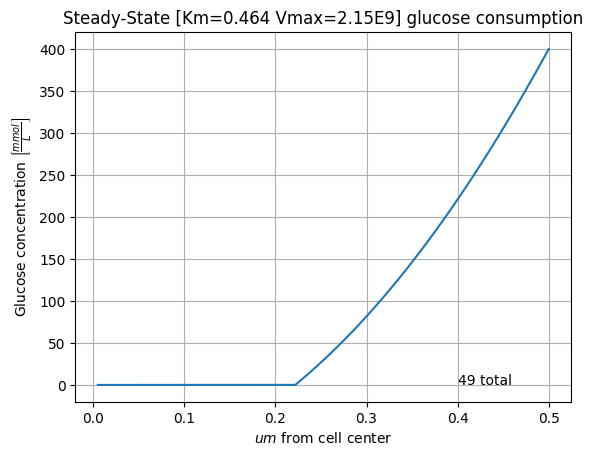

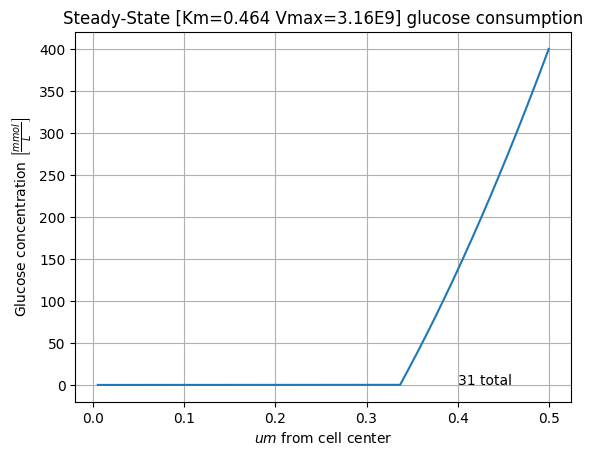

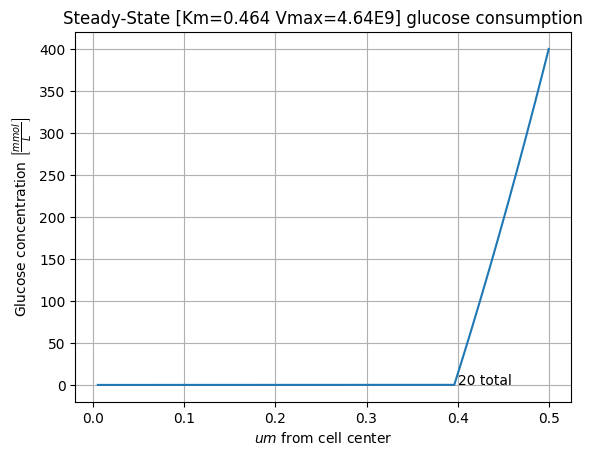

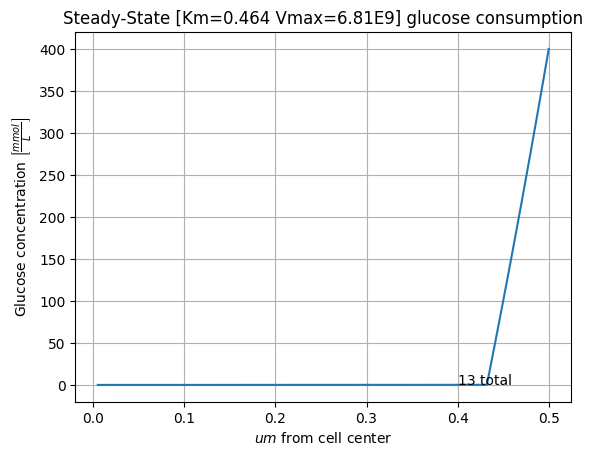

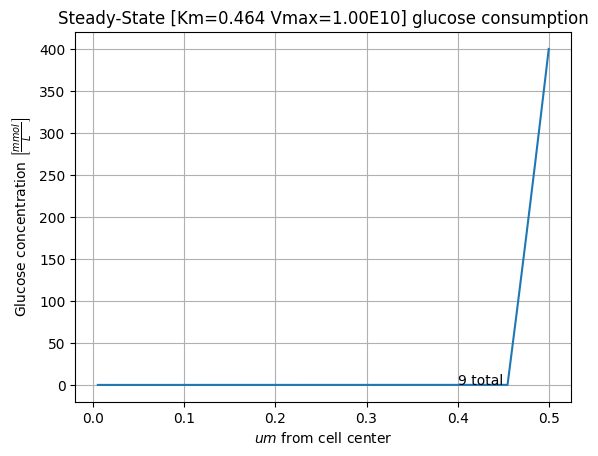

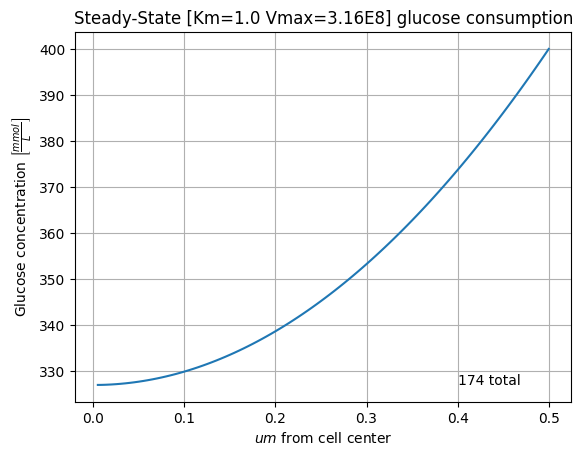

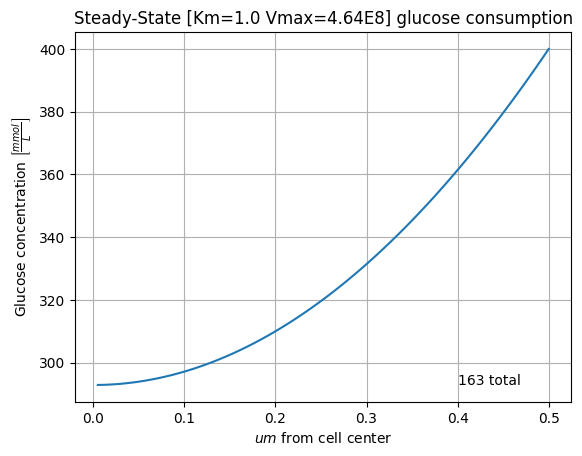

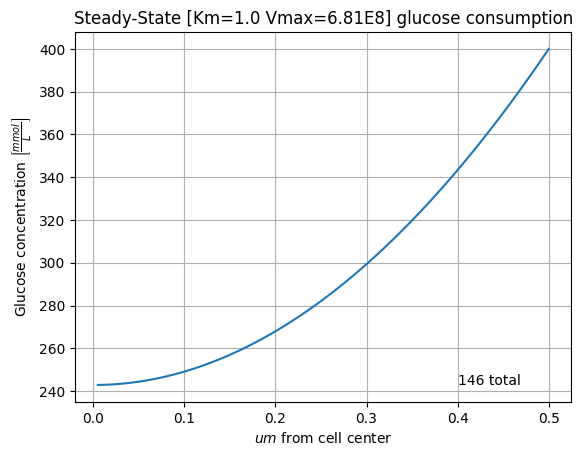

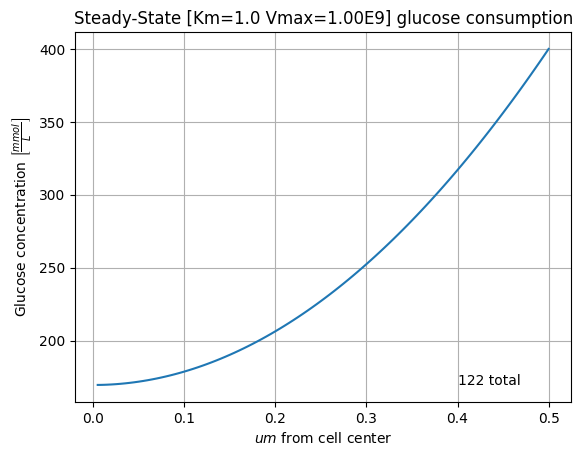

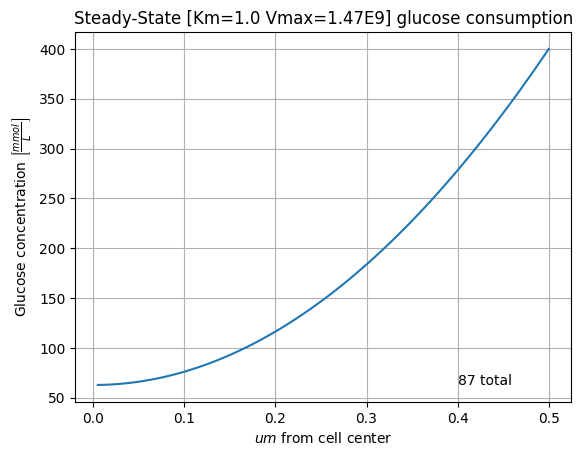

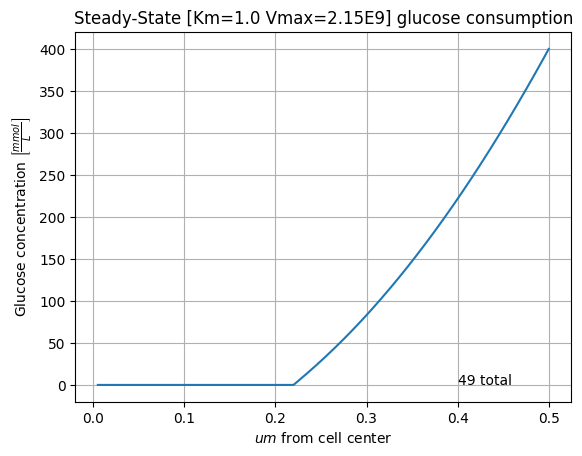

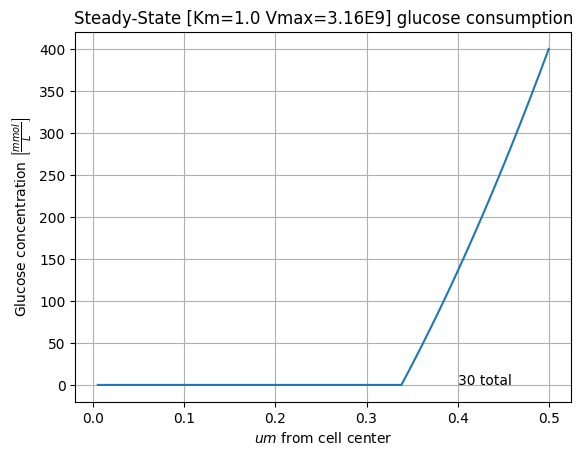

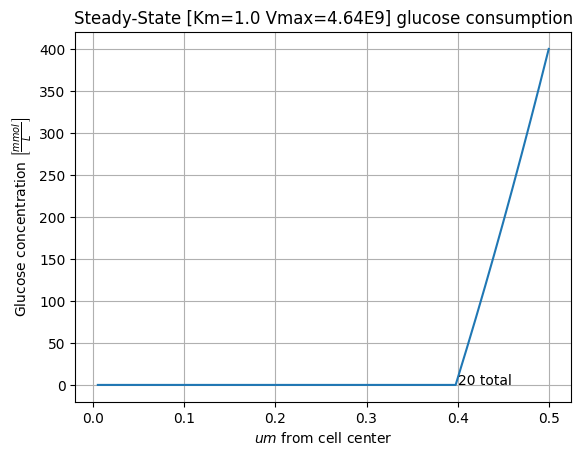

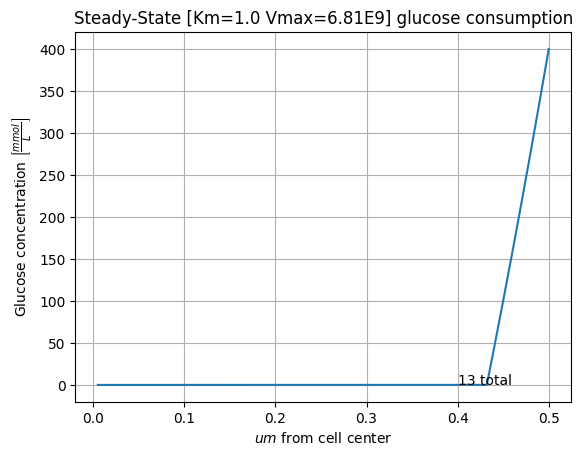

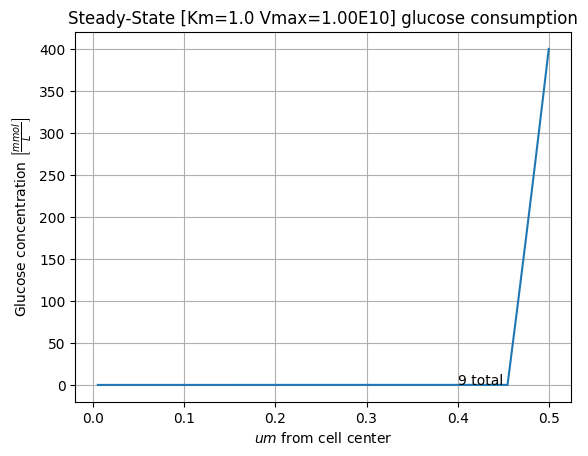

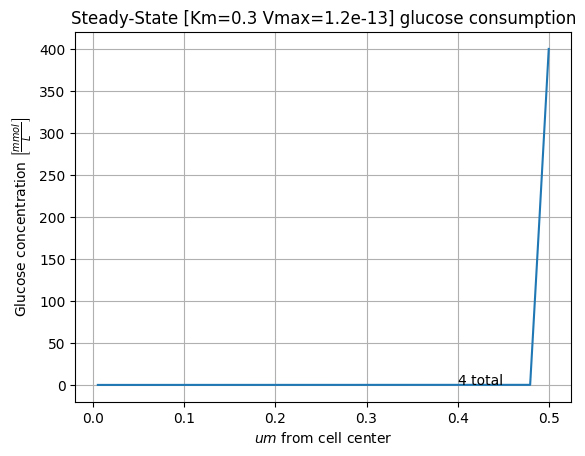

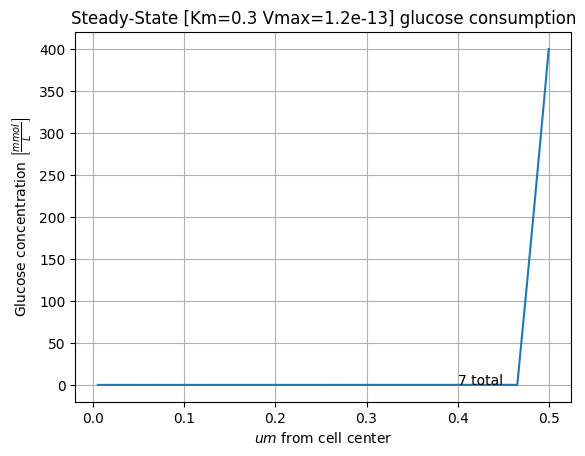

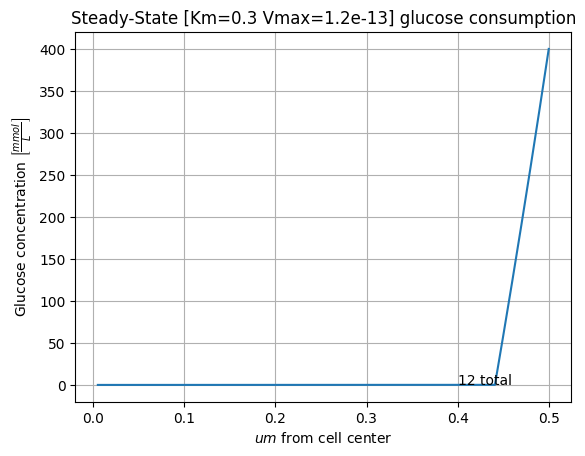

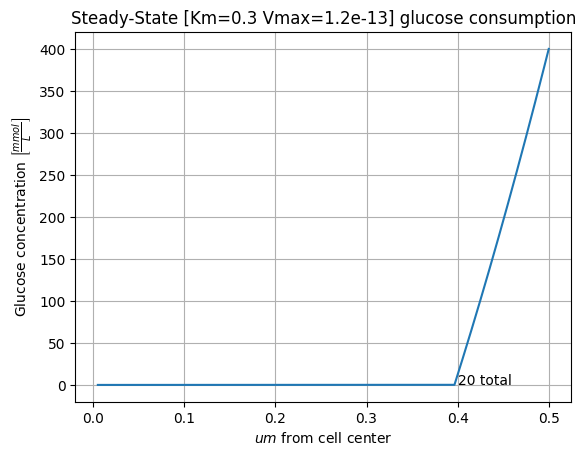

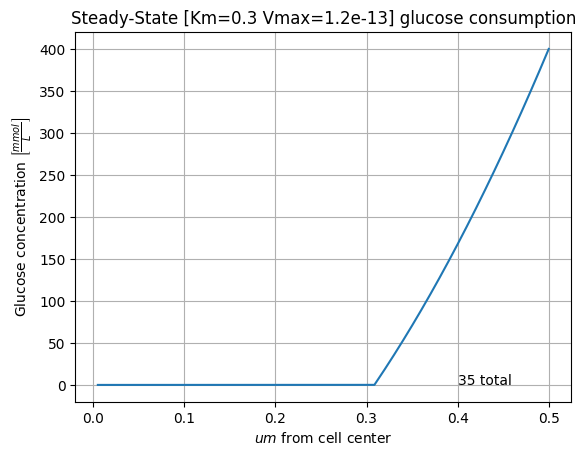

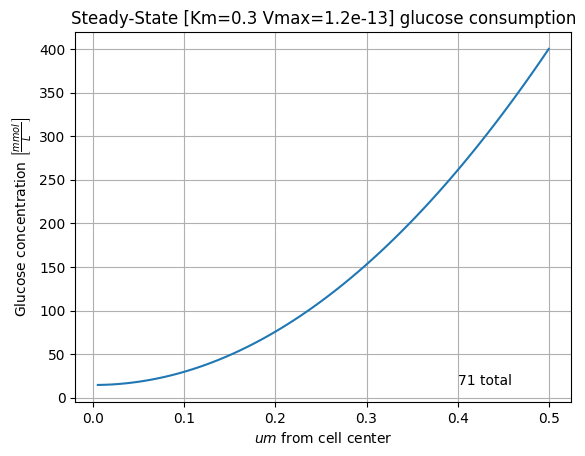

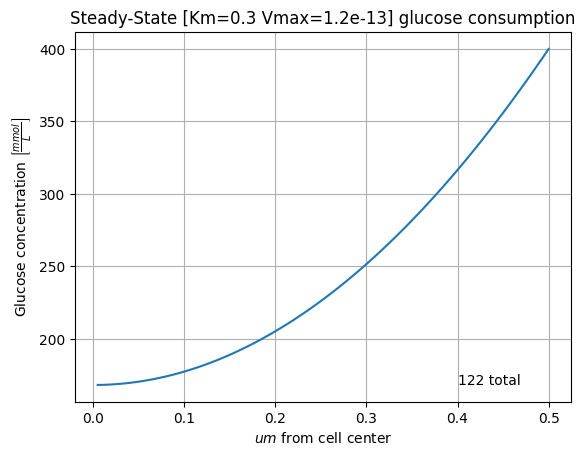

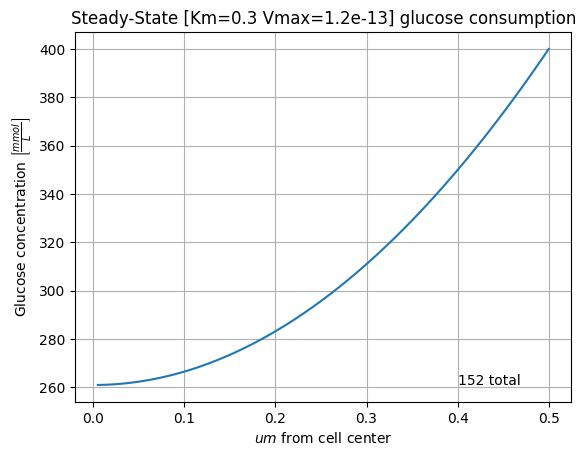

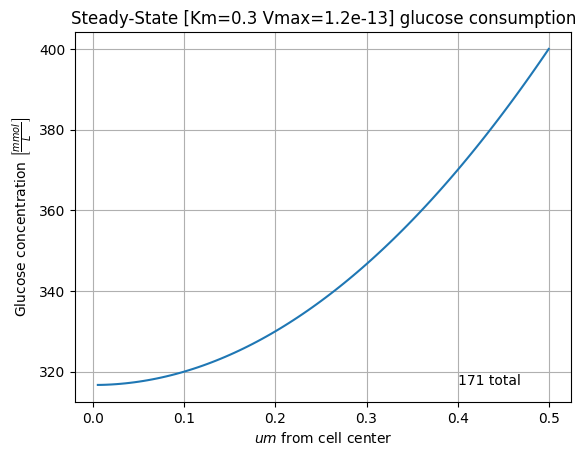

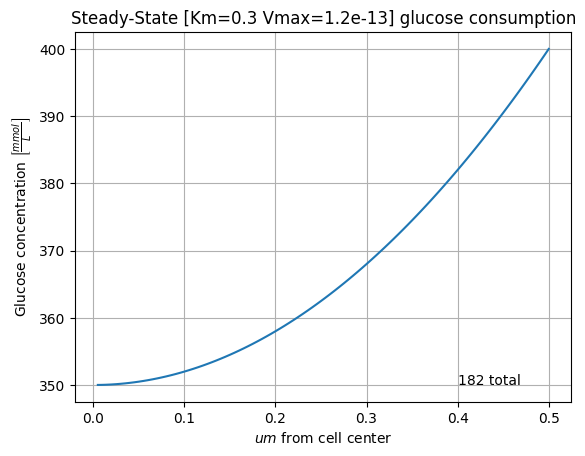

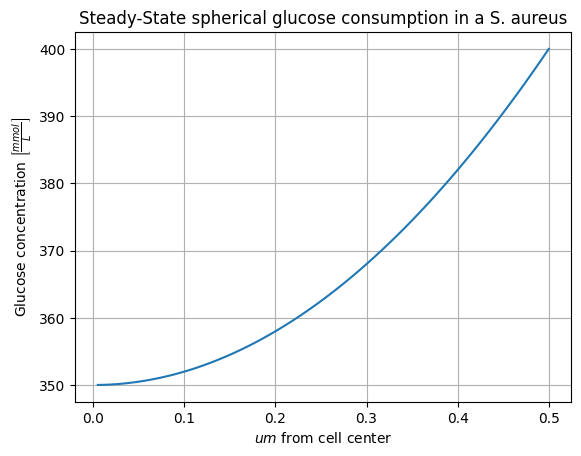

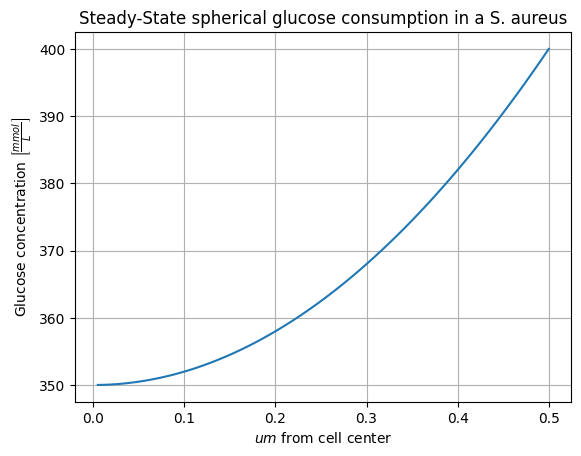

In [302]:
from numpy import array, vstack, linspace, zeros, logspace
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp, simps, trapz
import sigfig

# Parameters
D = 50*60*60  # um^2/hr Diffusivity
R = 0.5  # um radius
C_inf = 400  # mmol/L at r >= R
# k = 0.5  # Reaction rate coefficient (assumed linear for simplicity)
# Vmax = 30 * (1/1e6) * 60 * 5e-12 # mU/mg_PFK = umol/min*mg_PFK => mmol/(cell*hr)

# Define the ODE system
def MM(c):
    return (Vmax * c) / (Km + c)   # mmol/(cm^3*min)

def linear(c):   # TODO need to find a reaction constant for glucose consumption in a bacterium
    return -k * c  # Example reaction: first-order decay

def spherical_system(r, c):
    dC_dr = c[1]  # mmol/(cm^3 * um)
    d2C_dr2 = - (2 / r) * dC_dr + MM(c[0]) / D   # mmol/(cm^3 * um^2)
    return vstack((dC_dr, d2C_dr2))

# Boundary conditions
def dynamic_bc(C0, C_R):
    return array([C0[1], C_R[0] - C_inf])  # dC/dr at r=0 is 0, C(R) = C_inf

# Radial grid
numPoints = 100
r = linspace(R/numPoints, R, numPoints)  # Avoid division by zero

# Initial guess for concentration
C_guess = zeros((2, numPoints))
C_guess[0, :] = C_inf

# variable Km and Vmax
areas = {}
min_combo = [None, C_inf]
for Km in logspace(-3, 0, 10):
    areas[Km] = {}
    for Vmax in logspace(8.5, 10, 10):
        MM = lambda c: ((Vmax * c) / (Km + c))
        ODE = lambda r,c: vstack([c[1], - (2 / r) * c[1] + MM(c[0]) / D])
        sol = solve_bvp(ODE, dynamic_bc, r, C_guess)
        y = [max(0, y) for y in sol.y[0]]
        # print(max(sol.x), min(sol.x))
        area = simps(y, sol.x)
        # print(max(y), min(y), area)
        areas[Km][Vmax] = area
        if area < min_combo[1]: min_combo = [f"{Km}_{Vmax}", area]
        # print(f"{sigfig.round(area/(1e4)**3, 3)} mmol glucose absorbed in the cell, and {sigfig.round(area/max(sol.x), 3)} average concentration." )

        # Plot results
        fig = plt.figure()
        plt.plot(sol.x, y, label="Concentration Profile")
        plt.xlabel(r"$um$ from cell center")
        plt.ylabel(r"Glucose concentration $\left[\frac{mmol}{L}\right]$")
        plt.title(f"Steady-State [Km={sigfig.round(Km,3)} Vmax={sigfig.round(int(Vmax),3,format='scientific')}] glucose consumption")
        plt.text(0.8*R, min(y), f"{round(area)} total")
        plt.grid()
        fig.savefig(f"{Km}_{Vmax}.png")

print(min_combo)

# variable D
Km = 0.3 # mmol/L
Vmax = 4 * (1/1e3) * 60 * 5e-13  # mU PFK/cell = umol/min*mg_PFK => mmol/hr*cell
print(Vmax)
areas = {}
min_combo = [None, C_inf]
for D in logspace(-18, -16, 10):
    MM = lambda c: ((Vmax * c) / (Km + c))
    ODE = lambda r,c: vstack([c[1], - (2 / r) * c[1] + MM(c[0]) / D])
    sol = solve_bvp(ODE, dynamic_bc, r, C_guess)
    y = [max(0, y) for y in sol.y[0]]
    # print(max(sol.x), min(sol.x))
    area = simps(y, sol.x)
    # print(max(y), min(y), area)
    areas[D] = area
    if area < min_combo[1]: min_combo = [f"{Km}_{Vmax}", area]

    # Plot results
    fig = plt.figure()
    plt.plot(sol.x, y, label="Concentration Profile")
    plt.xlabel(r"$um$ from cell center")
    plt.ylabel(r"Glucose concentration $\left[\frac{mmol}{L}\right]$")
    plt.title(f"Steady-State [Km={sigfig.round(Km,3)} Vmax={sigfig.round(Vmax,3)}] glucose consumption")
    plt.text(0.8*R, min(y), f"{round(area)} total")
    plt.grid()
    fig.savefig(f"D={D}.png")

areas = {}
for kinetics in ["linear", "MM"]:                                                                                                                                                           
    for bs_system in ["constant_flux", "dynamic_flux"]:
        if bs_system == "constant_flux": bc = dynamic_bc  # TODO create a function and replace it here
        elif bs_system == "dynamic_flux": bc = dynamic_bc 

        sol = solve_bvp(spherical_system, bc, r, C_guess)
        sol.y[0] = [max(0, y) for y in sol.y[0]]
        area = simps(sol.y[0], sol.x)
        print(f"{sigfig.round(area/(1e4)**3, 3)} mmol glucose absorbed in the cell, and {sigfig.round(area/max(sol.x), 3)} average concentration." )

        # Plot results
        fig = plt.figure()
        plt.plot(sol.x, sol.y[0], label="Concentration Profile")
        plt.xlabel(r"$um$ from cell center")
        plt.ylabel(r"Glucose concentration $\left[\frac{mmol}{L}\right]$")
        plt.title(f"Steady-State spherical glucose consumption in a S. aureus")
        plt.grid()
        fig.savefig(f"spherical_{kinetics}_{bs_system}.png")
    break


# Analytical solution

In [289]:
Km = 0.3    # mmol/L
Vmax = 4 * (1/1e3) * 60 * 5e-13 * 5e-13   # mU/mg_PFK = umol/min*mg_PFK => mmol/(cell*hr) => mmol/(cm^3*hr)
ave_rxn = 135*Vmax / (135 + Km)
print(Km, Vmax, ave_rxn)

R_cm = R/10000     # cm
D_cm = D*60/(1e4)**2  # cm^2/hr
c_inf = 400/1000  # mmol/cm^3

# Radial grid
from numpy import logspace, linspace
import sigfig
concentrations = {}
rs = linspace(R_cm/numPoints, R_cm, 100)
for D_cm2 in logspace(-24,-23, 10):
    coefficient = ave_rxn/6/D_cm2
    for r in rs:
        concentrations[r] = max(0, (coefficient*(r**2 - R_cm**2) + c_inf)*1000)

    # print(concentrations.values())
    fig = plt.figure()
    plt.plot(list(concentrations.keys()), list(concentrations.values()), label="Concentration Profile")
    plt.xlabel(r"$cm$ from cell center")
    plt.ylabel(r"Glucose concentration $\left[\frac{mmol}{L}\right]$")
    plt.title(rf"Steady-State of $c$, D={sigfig.round(D_cm2, 3)}, in a S. aureus")
    plt.grid()
    y = list(concentrations.values())
    # print(max(sol.x), min(sol.x))
    area = simps(y, rs)
    plt.text(0.7, min(y), f"{round(area)} total")
    fig.savefig(f"analytical_sol_{D_cm2}.png")

0.3 5.999999999999999e-26 5.986696230598667e-26


/var/folders/j8/f5pb70wx5gn1qv1nz77lfhyr0000gn/T/ipykernel_82803/1882722280.py:25: UserWarning: 3 significant figures requested from number with only 1 significant figures
  plt.title(rf"Steady-State of $c$, D={sigfig.round(D_cm2, 3)}, in a S. aureus")
/var/folders/j8/f5pb70wx5gn1qv1nz77lfhyr0000gn/T/ipykernel_82803/1882722280.py:29: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  area = simps(y, rs)


ValueError: Image size of 6376647x473 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

ValueError: Image size of 6376656x473 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

ValueError: Image size of 6376647x473 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

ValueError: Image size of 6376647x473 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

ValueError: Image size of 6376631x473 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

ValueError: Image size of 6376631x473 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

ValueError: Image size of 6376631x473 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

ValueError: Image size of 6376631x473 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

ValueError: Image size of 6376647x473 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

ValueError: Image size of 6376647x473 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

In [281]:
print(D_cm, R_cm)


3e-05 5e-05


/var/folders/j8/f5pb70wx5gn1qv1nz77lfhyr0000gn/T/ipykernel_82803/3628122023.py:25: UserWarning: 3 significant figures requested from number with only 1 significant figures
  plt.plot(rs*R, calcs, label=f'Da={sigfig.round(Da, 3)}', color=color)
/var/folders/j8/f5pb70wx5gn1qv1nz77lfhyr0000gn/T/ipykernel_82803/3628122023.py:25: UserWarning: 3 significant figures requested from number with only 2 significant figures
  plt.plot(rs*R, calcs, label=f'Da={sigfig.round(Da, 3)}', color=color)


0.006 5e-05

Da	k		area
0.1	2.40E5		395
0.215	5.16E5		390
0.464	1.11E6		380
1.0	2.40E6		359
2.15	5.16E6		322
4.64	1.11E7		262
10.0	2.40E7		188
21.5	5.16E7		119
46.4	1.11E8		72
100.0	2.40E8		45


/var/folders/j8/f5pb70wx5gn1qv1nz77lfhyr0000gn/T/ipykernel_82803/3628122023.py:38: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  AUCs[sigfig.round(float(Da), 3)] = sigfig.round(int(simps(calcs, rs)), 3)
/var/folders/j8/f5pb70wx5gn1qv1nz77lfhyr0000gn/T/ipykernel_82803/3628122023.py:38: UserWarning: 3 significant figures requested from number with only 1 significant figures
  AUCs[sigfig.round(float(Da), 3)] = sigfig.round(int(simps(calcs, rs)), 3)
/var/folders/j8/f5pb70wx5gn1qv1nz77lfhyr0000gn/T/ipykernel_82803/3628122023.py:38: UserWarning: 3 significant figures requested from number with only 2 significant figures
  AUCs[sigfig.round(float(Da), 3)] = sigfig.round(int(simps(calcs, rs)), 3)


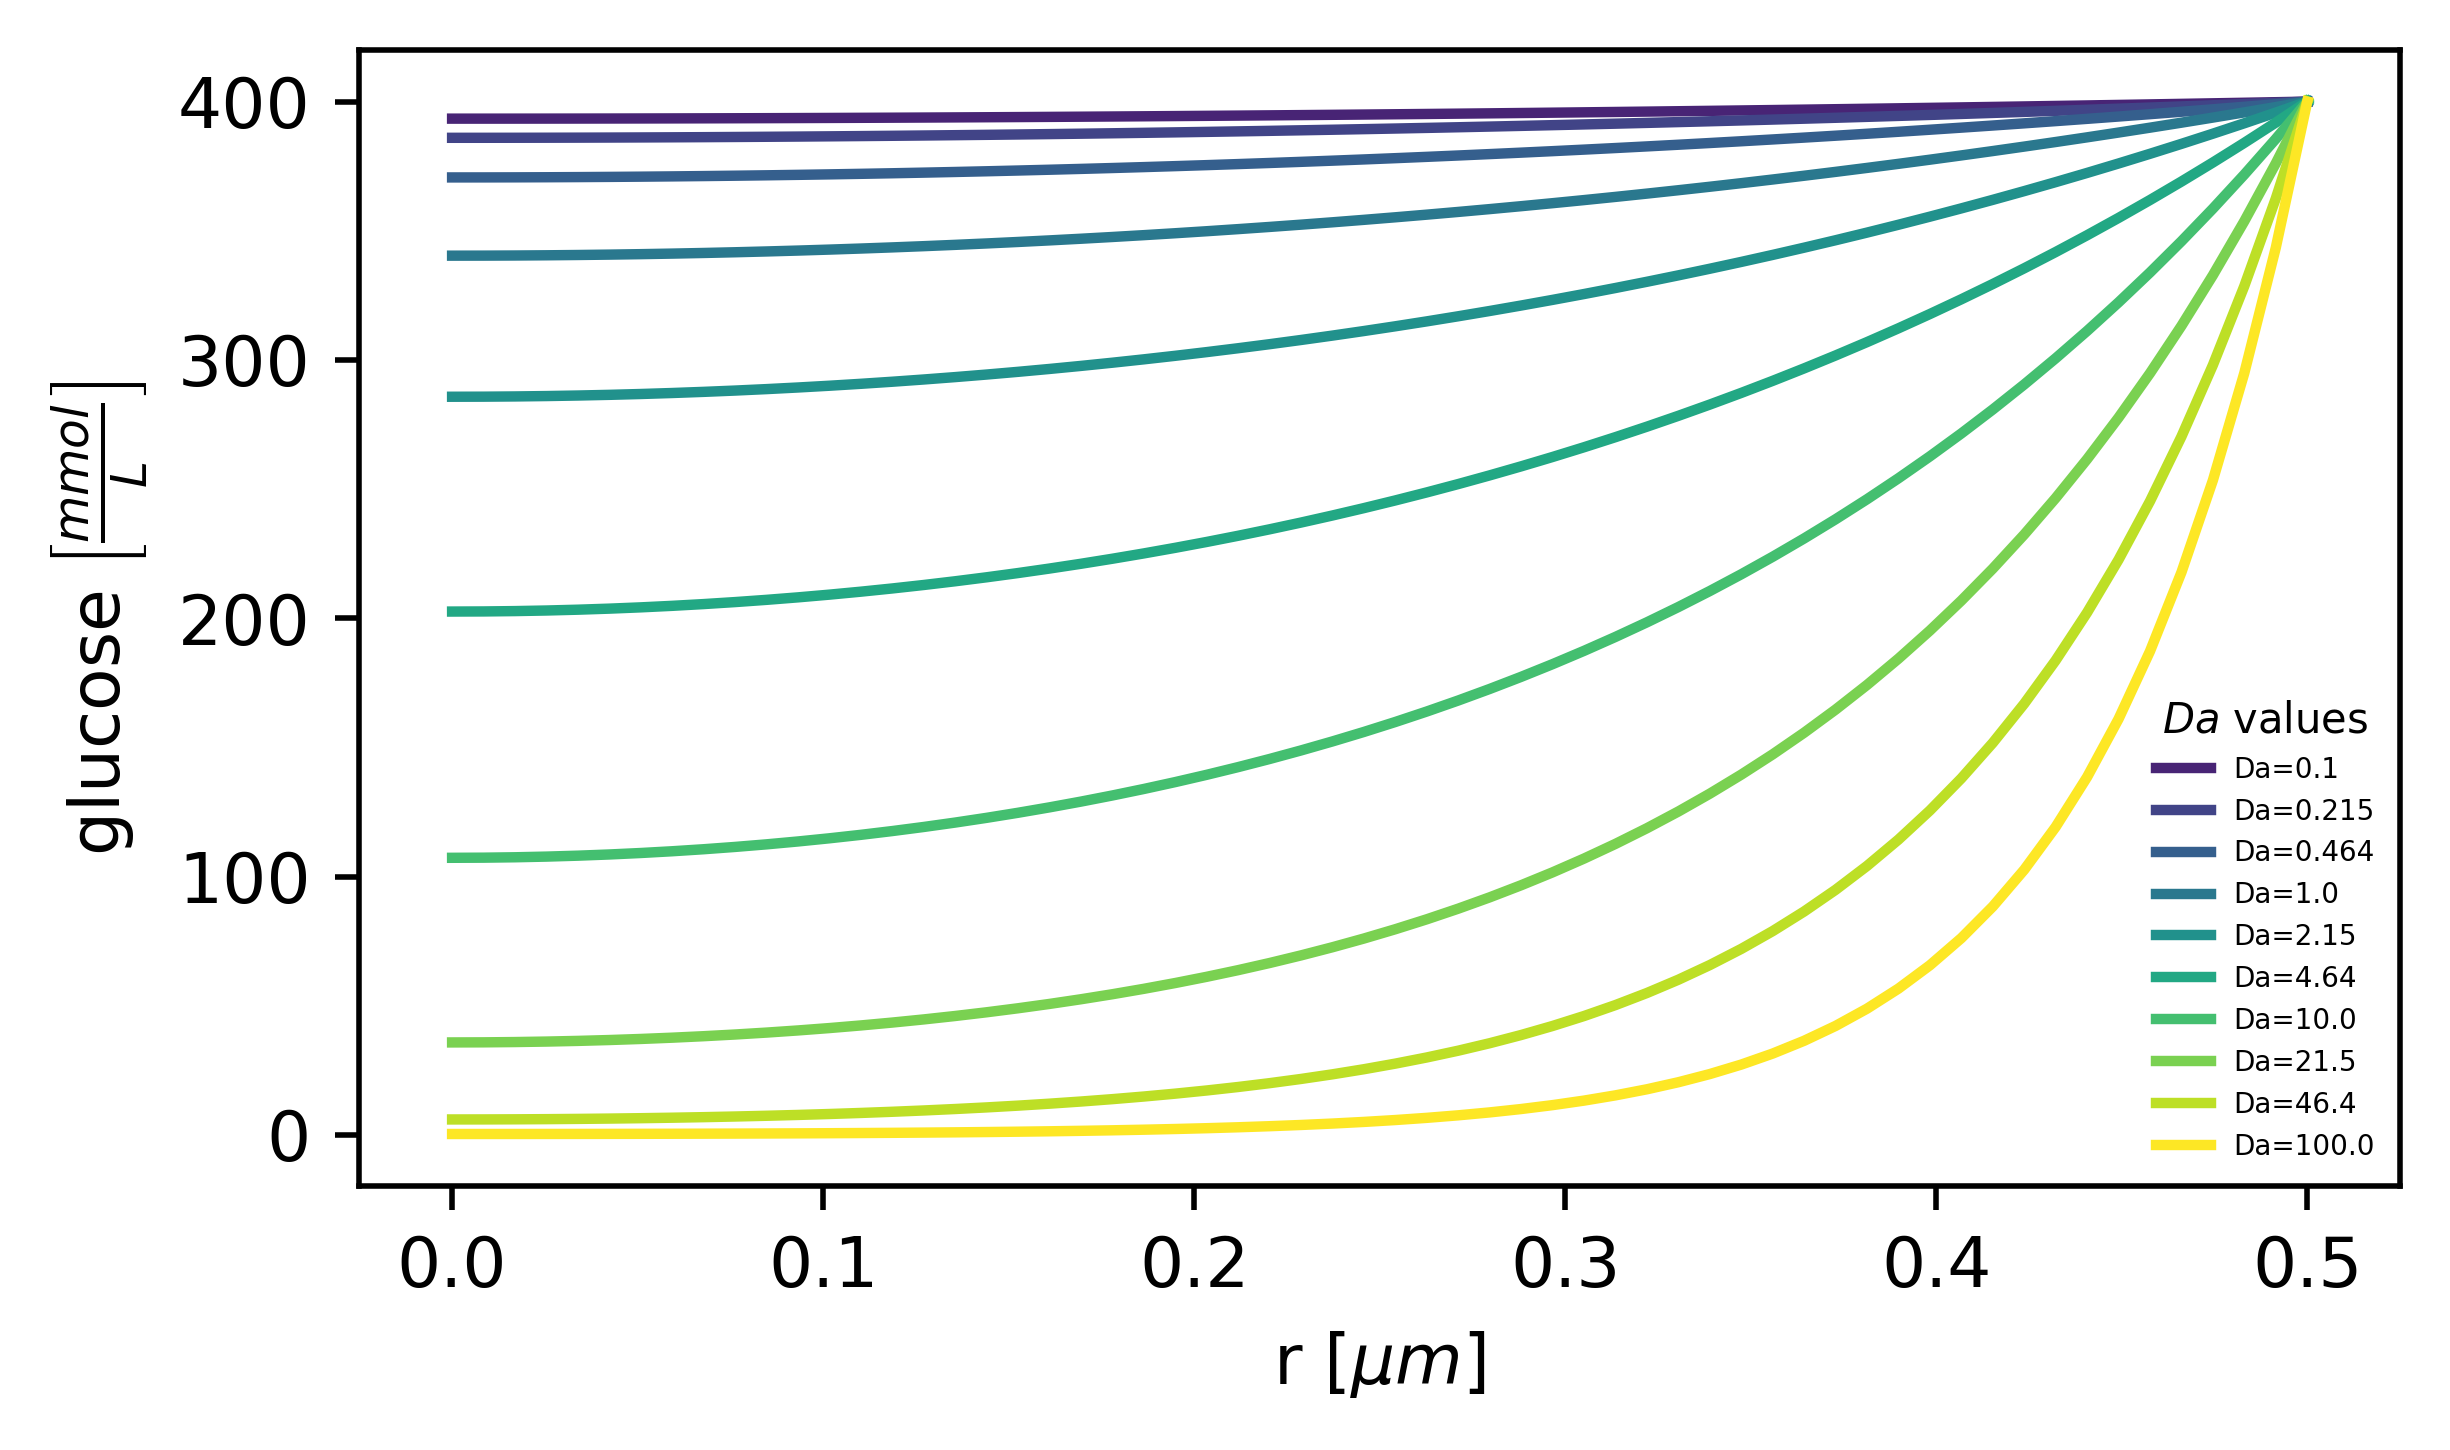

In [288]:
import matplotlib.pyplot as plt
from numpy import sinh, ones, linspace, logspace
import matplotlib.cm as cm
import sigfig

def calculation(rs, Da):
    z = rs * Da**0.5
    ans = ones(len(rs))
    ## Division by zero is undefined
    mask = rs != 0
    ans[mask] = sinh(z[mask]) / (rs[mask] * sinh(Da**0.5))
    ## Handle the exception
    mask = rs == 0
    ans[mask] = Da**0.5 / sinh(Da**0.5)
    return ans*400

# Generate a colormap
rs = linspace(0, 1, 60)
colors = cm.viridis(linspace(0.1, 1, 10))
fig = plt.figure(dpi=500, figsize=(5,3))
vals = {}
for Da, color in zip(logspace(-1, 2, 10), colors):
    calcs = calculation(rs, Da)
    vals[Da] = calcs
    plt.plot(rs*R, calcs, label=f'Da={sigfig.round(Da, 3)}', color=color)

plt.ylabel(r'glucose $\left[\frac{mmol}{L}\right]$')
plt.xlabel(r'r [$\mu m$]')
plt.legend(title=r"$Da$ values", title_fontsize=6, fontsize=4, frameon=False)
plt.tight_layout()
fig.savefig("variable_Da.png")

# process the outputs to find the AUC for each Da value
from scipy.integrate import simps
import sigfig
AUCs = {}
for Da, calcs in vals.items():
    AUCs[sigfig.round(float(Da), 3)] = sigfig.round(int(simps(calcs, rs)), 3)

print(D_cm,R_cm)
print("\nDa\tk\t\tarea")
for Da,v in AUCs.items():
    k = Da*D_cm/R_cm**2
    # D = (R_cm**2)/Da
    print(f"{Da}\t{sigfig.round(k, 3, format='scientific')}\t\t{v}")

/var/folders/j8/f5pb70wx5gn1qv1nz77lfhyr0000gn/T/ipykernel_82803/2678364619.py:41: RuntimeWarning: overflow encountered in scalar add
  D * (C[i+1, j] - 2*C[i, j] + C[i-1, j]) / dx**2 +
/var/folders/j8/f5pb70wx5gn1qv1nz77lfhyr0000gn/T/ipykernel_82803/2678364619.py:41: RuntimeWarning: overflow encountered in scalar divide
  D * (C[i+1, j] - 2*C[i, j] + C[i-1, j]) / dx**2 +
/var/folders/j8/f5pb70wx5gn1qv1nz77lfhyr0000gn/T/ipykernel_82803/2678364619.py:42: RuntimeWarning: overflow encountered in scalar divide
  D * (C[i, j+1] - 2*C[i, j] + C[i, j-1]) / dy**2
/var/folders/j8/f5pb70wx5gn1qv1nz77lfhyr0000gn/T/ipykernel_82803/2678364619.py:40: RuntimeWarning: invalid value encountered in scalar add
  C_new[i, j] = C[i, j] + dt * (
/var/folders/j8/f5pb70wx5gn1qv1nz77lfhyr0000gn/T/ipykernel_82803/2678364619.py:48: RuntimeWarning: invalid value encountered in subtract
  C_new[0, :] = C_new[1, :] - kc * dy / D * (C_new[1, :] - C_new[0, :])  # Convection at the bottom
/var/folders/j8/f5pb70wx5gn1q

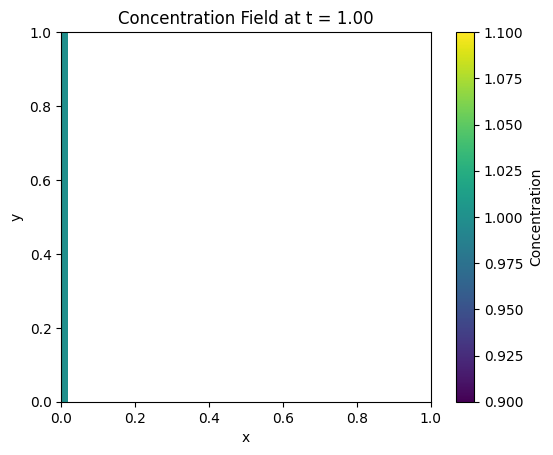

In [ ]:
# ## Define the parameters of your system ##
# # Parameters
# Lx = 1.0  # Length of the domain in x-direction
# Ly = 2*0.5  # Length of the domain in y-direction (H=0.5 let's say)
# D = 1   # Diffusion coefficient (m2/s)
# T = 1   # Total time (s)
# kc= 1.0 # mass transport coefficient (s/M)
# kr= 1.0 # reaction rate (1/s)


# ## Discretization of the domain ##
# Nx = 50   # Number of grid points in x-direction
# Ny = 50   # Number of grid points in y-direction
# Nt= 1000    # Number of grid points in time
# dx = Lx / (Nx - 1) # Grid spacing in x-direction
# dy = Ly / (Ny - 1) # Grid spacing in y-direction
# dt= T / (Nt - 1) # Time step size


# ## Boundary conditions
# C = np.zeros((Nx, Ny))

# ## BC1: C = 1.0 at x = -Lx/2
# C[:, 0] = 1.0  # Set concentration on the left side
# ## BC2: dC/dx = 0 at x = Lx/2
# C[:, -1] = C[:, -2]  # No flux on the right side
# ## BC3: dC/dy = -kc/D*(C(y=-H))
# C[0, :] = C[1, :] - kc* dy / D * (C[1, :] - C[0, :])  # Convection at the bottom
# ## BC4: dC/dy = kc/D*(C(y=H))
# C[-1, :] = C[-2, :] + kc * dy / D * (C[-1, :] - C[-2, :])  # Convection at the top




# # Finite difference method
# for n in range(Nt):  # for each time
#     C_new = C.copy()
#     for i in range(1, Nx-1):  # for each x
#         for j in range(1, Ny-1):  # for each y
#             C_new[i, j] = C[i, j] + dt * (
#                 D * (C[i+1, j] - 2*C[i, j] + C[i-1, j]) / dx**2 +
#                 D * (C[i, j+1] - 2*C[i, j] + C[i, j-1]) / dy**2
#             - kr * C[i, j]
#             )
#     # Update boundary conditions
#     C_new[:, 0] = 1.0  # Set concentration on the left side
#     C_new[:, -1] = C_new[:, -2]  # No flux on the right side
#     C_new[0, :] = C_new[1, :] - kc * dy / D * (C_new[1, :] - C_new[0, :])  # Convection at the bottom
#     C_new[-1, :] = C_new[-2, :] + kc * dy / D * (C_new[-1, :] - C_new[-2, :])  # Convection at the top
#     C = C_new.copy()

# # Plot the final concentration field
# plt.imshow(C, extent=[0, Lx, 0, Ly], origin='lower', cmap='viridis')
# plt.colorbar(label='Concentration')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Concentration Field at t = {:.2f}'.format(T))
# plt.show()

# FBA comparison

In [69]:
from cobra.io import load_json_model

model = load_json_model("iYS854.json")

{'EX_h2o_e': 10.0,
 'EX_h_e': 10.0,
 'EX_k_e': 10.0,
 'EX_ca2_e': 10.0,
 'EX_cl_e': 10.0,
 'EX_co2_e': 10.0,
 'EX_cobalt2_e': 10.0,
 'EX_cu2_e': 10.0,
 'EX_cys__L_e': 10.0,
 'EX_mg2_e': 10.0,
 'EX_mn2_e': 10.0,
 'EX_mobd_e': 10.0,
 'EX_na1_e': 10.0,
 'EX_fe2_e': 10.0,
 'EX_fe3_e': 10.0,
 'EX_nac_e': 10.0,
 'EX_nh4_e': 10.0,
 'EX_ni2_e': 10.0,
 'EX_o2_e': 20.0,
 'EX_pi_e': 10.0,
 'EX_glc__D_e': 10.0,
 'EX_so4_e': 10.0,
 'EX_thm_e': 10.0,
 'EX_zn2_e': 10.0}

In [77]:
model.medium = {'EX_h2o_e': 10.0,
 'EX_h_e': 10.0,
 'EX_k_e': 10.0,
 'EX_ca2_e': 10.0,
 'EX_cl_e': 10.0,
 'EX_co2_e': 10.0,
 'EX_cobalt2_e': 10.0,
 'EX_cu2_e': 10.0,
 'EX_cys__L_e': 10.0,
 'EX_mg2_e': 10.0,
 'EX_mn2_e': 10.0,
 'EX_mobd_e': 10.0,
 'EX_na1_e': 10.0,
 'EX_fe2_e': 10.0,
 'EX_fe3_e': 10.0,
 'EX_nac_e': 10.0,
 'EX_nh4_e': 10.0,
 'EX_ni2_e': 10.0,
 'EX_o2_e': 20.0,
 'EX_pi_e': 10.0,
 'EX_glc__D_e': 400.0,
 'EX_so4_e': 10.0,
 'EX_thm_e': 10.0,
 'EX_zn2_e': 10.0}
display(model.medium)

{'EX_h2o_e': 10.0,
 'EX_h_e': 10.0,
 'EX_k_e': 10.0,
 'EX_ca2_e': 10.0,
 'EX_cl_e': 10.0,
 'EX_co2_e': 10.0,
 'EX_cobalt2_e': 10.0,
 'EX_cu2_e': 10.0,
 'EX_cys__L_e': 10.0,
 'EX_mg2_e': 10.0,
 'EX_mn2_e': 10.0,
 'EX_mobd_e': 10.0,
 'EX_na1_e': 10.0,
 'EX_fe2_e': 10.0,
 'EX_fe3_e': 10.0,
 'EX_nac_e': 10.0,
 'EX_nh4_e': 10.0,
 'EX_ni2_e': 10.0,
 'EX_o2_e': 20.0,
 'EX_pi_e': 10.0,
 'EX_glc__D_e': 400.0,
 'EX_so4_e': 10.0,
 'EX_thm_e': 10.0,
 'EX_zn2_e': 10.0}

In [78]:
sol = model.optimize()
display(sol)
print(sol.fluxes.EX_glc__D_e)

<Solution 5.026 at 0x35201f850>

-99.12731491918191
